In [1]:
import pandas as pd
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import pdb
import scipy
from scipy.optimize import minimize, fmin
from scipy.stats import multivariate_normal
import xlrd
from tqdm.notebook import tqdm
import matplotlib
from mpl_toolkits import mplot3d
import pingouin as pg
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['tahoma']

In [15]:
""" 
Obtaining data from a given long context expt
"""
Test = pd.read_csv('../auditory_categorization_noContext/important_things_not_included_in_assets/allTrials.csv')
Data = pd.read_csv('auditory_categorization_prolific_online_data/human_auditory_categorization_91686_2022-01-19_20h56.51_f8da6647-2fb7-444d-9e8c-e52b3a37d4b2/6148fa16224d9a3182bb1871_categorization_task_2021-10-02_15h28.33.682.csv');

TestLc = pd.read_csv('../auditory_categorization_longLow/important_things_not_included_in_assets/allTrials.csv')
DataLc = pd.read_csv('auditory_categorization_lc_online_data/auditory_categorization_v2_119865_2021-10-07_14h10.37_f5bf4a3a-1cbd-4b5c-9de5-23da829018ed/6148fa16224d9a3182bb1871_categorization_task_longLow_2021-09-23_13h27.00.880.csv');

TestHc = pd.read_csv('../auditory_categorization_longHigh/important_things_not_included_in_assets/allTrials.csv')
DataHc = pd.read_csv('auditory_categorization_Hc_online_data/auditory_categorization_v3_143976_2022-01-24_22h25.18_d46bc498-64c0-4529-b32c-606dccb68ddf/6148fa16224d9a3182bb1871_categorization_task_longHigh_2021-10-20_11h28.03.977.csv');

xls = pd.ExcelFile('clusterResultsForSubsampledData.xls')


In [16]:
def extractData(csv_test, csv_data, exptTotalLength, exptLengthWithBreaks):  
    n_tones=3
    n_trials = csv_data.shape[0]-47

    test_columns = list(csv_test.columns)
    test_tones_name = test_columns.index('Name')
    test_tones_col_idx = test_columns.index('Tones')
    df_names = (csv_test.iloc[0:exptTotalLength,test_tones_name]).values
    df_tones = (csv_test.iloc[0:exptTotalLength,test_tones_col_idx]).values

    tones_array_orig = np.zeros((n_trials,n_tones))
    tones_array_idxs_keep = []

    for i_wav in range(exptLengthWithBreaks):
        if isinstance(csv_data['Name'][i_wav+46],str):
            tones_array_orig[i_wav,:] = np.array(df_tones[np.where(csv_data['Name'][i_wav+46]\
                                                              ==df_names)[0]][0][1:-1].split(',')).astype(float)  
            tones_array_idxs_keep += [i_wav]


    exptTones = np.copy(tones_array_orig[tones_array_idxs_keep,:])
    exptCorrans = np.copy(csv_data['corrAns'][46:csv_data.shape[0]])[tones_array_idxs_keep]
    exptKeys = np.copy(csv_data['test_resp.keys'][46:csv_data.shape[0]])[tones_array_idxs_keep]
    
    return exptTones, exptCorrans, exptKeys

def identifyResponseTrials(keysPressed, correctAns, tonesPlayed, exptTotalLength):
    no_response = np.intersect1d(np.where(keysPressed!='h')[0],
                                 np.where(keysPressed!='l')[0])
    #print("Did not respond to: ",no_response)

    """
    Convert keys ['l','h'] to [0,1]
    """

    corrans_num_orig = np.zeros_like(correctAns)
    corrans_num_orig[correctAns == 'h'] = 1

    keys_num_orig = np.zeros_like(keysPressed)
    keys_num_orig[keysPressed == 'h'] = 1

    corrans_num = corrans_num_orig[:exptTotalLength]
    keys_num = keys_num_orig[:exptTotalLength]
    tones_array = tonesPlayed[:exptTotalLength]

    trial_tones = np.repeat(tones_array,1,axis = 0)
    trial_behaviour = np.reshape(keys_num,np.prod(keys_num.shape)) 
    idxs_with_response = np.delete(np.arange(len(trial_tones)),no_response)
    trialTonesResponded = trial_tones[idxs_with_response,:]
    trialBehaviourResponded = trial_behaviour[idxs_with_response]
    corransResponded = corrans_num[idxs_with_response]
    #print(f"Total trials played are {len(trial_tones)}, and total trials responded to are {len(trialTonesResponded)}")
    #print("Got correct: ", np.sum(trialBehaviourResponded==corransResponded)/len(trialTonesResponded))
    #print("No. of minority category correct: ", np.sum(keys_num*corrans_num)/np.sum(corrans_num))
    
    return trialTonesResponded, trialBehaviourResponded, corransResponded


def plottingInfluenceFn(tones, behaviour):
    unique_tones = np.unique(tones)

    tone1_prob_behaviour = np.zeros((len(unique_tones)))
    tone2_prob_behaviour = np.zeros((len(unique_tones)))
    tone3_prob_behaviour = np.zeros((len(unique_tones)))

    for i_tone in range(len(unique_tones)):
        tone1_prob_behaviour[i_tone] = np.mean(behaviour[tones[:,0]==unique_tones[i_tone]])
        tone2_prob_behaviour[i_tone] = np.mean(behaviour[tones[:,1]==unique_tones[i_tone]])
        tone3_prob_behaviour[i_tone] = np.mean(behaviour[tones[:,2]==unique_tones[i_tone]])
    mean_behaviour = (tone1_prob_behaviour+tone2_prob_behaviour+tone3_prob_behaviour)/3
    return unique_tones, mean_behaviour    
    

In [17]:
def noContextData(keys, corrans, tones):
    trial_tones_expt, trial_behaviour_expt, corrans_expt = identifyResponseTrials(keysPressed = keys, 
                                                                                correctAns = corrans, 
                                                                                tonesPlayed = tones, 
                                                                                exptTotalLength = 600)

    #print("Got correct: ", np.sum(trial_behaviour_expt==corrans_expt)/len(trial_tones_expt))
    return trial_tones_expt, trial_behaviour_expt

"""
Subsample the long context expt with a low category bias
"""
def subsampleLongContextLow(keyslc, corranslc, toneslc):
    trial_tones_fulllc, trial_behaviour_fulllc, corrans_fulllc = identifyResponseTrials(keysPressed = keyslc, 
                                                                                        correctAns = corranslc, 
                                                                                        tonesPlayed = toneslc, 
                                                                                        exptTotalLength = 800)
    idxHigh = np.arange(len(trial_behaviour_fulllc[0:]))[corrans_fulllc[0:]==1]
    idxLow = np.arange(len(trial_behaviour_fulllc[0:]))[corrans_fulllc[0:]==0]
    idxOfSmallerCategory = np.random.choice(idxLow,size=len(idxHigh),replace=False)
    idxToKeep = np.concatenate((idxHigh, idxOfSmallerCategory))
    corrans_exptlc = corrans_fulllc[0:][idxToKeep]
    trial_behaviour_exptlc = trial_behaviour_fulllc[0:][idxToKeep]
    trial_tones_exptlc = trial_tones_fulllc[0:][idxToKeep,:]
    #print("Got correct: ", np.sum(trial_behaviour_exptlc==corrans_exptlc)/len(trial_tones_exptlc))
    return trial_tones_exptlc, trial_behaviour_exptlc

"""
Subsample the long context expt with a high category bias
"""
def subsampleLongContextHigh(keyshc, corranshc, toneshc):
    trial_tones_fullhc, trial_behaviour_fullhc, corrans_fullhc = identifyResponseTrials(keysPressed = keyshc, 
                                                                                        correctAns = corranshc, 
                                                                                        tonesPlayed = toneshc, 
                                                                                        exptTotalLength = 800)
    idxHigh = np.arange(len(trial_behaviour_fullhc[0:]))[corrans_fullhc[0:]==1]
    idxLow = np.arange(len(trial_behaviour_fullhc[0:]))[corrans_fullhc[0:]==0]
    idxOfSmallerCategory = np.random.choice(idxHigh,size=len(idxLow),replace=False)
    idxToKeep = np.concatenate((idxLow, idxOfSmallerCategory))
    corrans_expthc = corrans_fullhc[0:][idxToKeep]
    trial_behaviour_expthc = trial_behaviour_fullhc[0:][idxToKeep]
    trial_tones_expthc = trial_tones_fullhc[0:][idxToKeep,:]
    #print("Got correct: ", np.sum(trial_behaviour_expthc==corrans_expthc)/len(trial_tones_expthc))
    return trial_tones_expthc, trial_behaviour_expthc

"""
Using raw data to calculate any inherent bias the subject develops
"""
def bias(trial_behaviour_longContext):
    return np.mean(trial_behaviour_longContext)
    

/Users/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in long_scalars
  ret = ret / rcount


length of subsample dataset in low context 464
length of subsample dataset in high context 452
p(L) given the no context is likely to be:  0.474036850921273
P(L) given the long context data biased towards low is likely to be:  0.2804956896551724
P(L) given the long context data biased towards high is likely to be:  0.7967920353982302
[0.46666667 0.3        0.46666667 0.36507937 0.59047619 0.30952381
 0.39090909 0.30555556 0.23518519 0.21917613 0.22720992 0.20876635
 0.20353303 0.31140873 0.30912698 0.47392767 0.57513412 0.70779221
 0.72581699 0.78996101 0.70277778 0.73974359 0.4489899  0.74054622
 0.81944444 0.93939394 0.48611111 0.85353535 0.77380952 0.85      ]
[1.95424251 2.00432137 2.05690485 2.11058971 2.161368   2.21484385
 2.26717173 2.31806333 2.37106786 2.42324587 2.47421626 2.52633928
 2.57863921 2.63042788 2.68304704 2.73479983 2.78675142 2.83884909
 2.8909796  2.94299959 2.99519629 3.04688519 3.09898964 3.15106325
 3.20303289 3.25527251 3.30728205 3.35926616 3.41128291 3.46

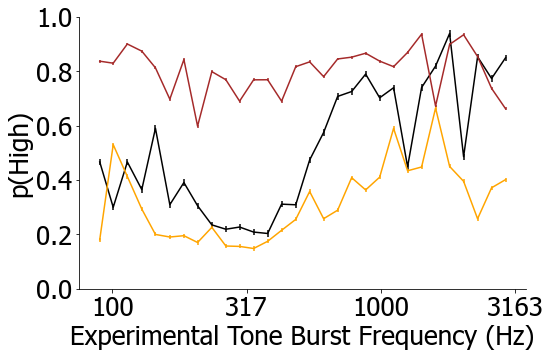

In [18]:
"""
Subsampling n times to find mean and sem of bias (n=20).
"""

df_tones, df_corrans, df_keys = extractData(csv_test=Test, 
                                            csv_data=Data, 
                                            exptTotalLength=600, 
                                            exptLengthWithBreaks=603) 

df_toneslc, df_corranslc, df_keyslc = extractData(csv_test=TestLc, 
                                                csv_data=DataLc, 
                                                exptTotalLength=800, 
                                                exptLengthWithBreaks=804) 


df_toneshc, df_corranshc, df_keyshc = extractData(csv_test=TestHc, 
                                                csv_data=DataHc, 
                                                exptTotalLength=800, 
                                                exptLengthWithBreaks=804) 

meanBiaslc = 0; meanBiashc = 0
numberOfSubsamples = 20
unique_tones_played = np.empty((numberOfSubsamples,30))
subjectBehaviour = np.empty((numberOfSubsamples,30))
subjectBehaviourLC = np.empty((numberOfSubsamples,30))
subjectBehaviourHC = np.empty((numberOfSubsamples,30))
for iSubsample in range(numberOfSubsamples):
    sampledlc_tones, sampledlc_behaviour = subsampleLongContextLow(toneslc=df_toneslc, 
                                                                   corranslc=df_corranslc, 
                                                                   keyslc=df_keyslc)
    sampledhc_tones, sampledhc_behaviour = subsampleLongContextHigh(toneshc=df_toneshc, 
                                                                    corranshc=df_corranshc, 
                                                                    keyshc=df_keyshc)
    noContext_tones, noContext_behaviour = noContextData(keys=df_keys,
                                                         corrans=df_corrans,
                                                         tones=df_tones)
    
    unique_tones_played[iSubsample,:], subjectBehaviour[iSubsample,:] = plottingInfluenceFn(noContext_tones, 
                                                                                        noContext_behaviour)   
    
    unique_tones_played[iSubsample,:], subjectBehaviourLC[iSubsample,:] = plottingInfluenceFn(sampledlc_tones, 
                                                                                            sampledlc_behaviour)    
    meanBiaslc += bias(sampledlc_behaviour)
    
    unique_tones_played[iSubsample,:], subjectBehaviourHC[iSubsample,:] = plottingInfluenceFn(sampledhc_tones,
                                                                                        sampledhc_behaviour)        
    meanBiashc += bias(sampledhc_behaviour)
    
print("length of subsample dataset in low context", len(sampledlc_tones))
print("length of subsample dataset in high context", len(sampledhc_tones))
    
print("p(L) given the no context is likely to be: ",np.mean(noContext_behaviour))
print("P(L) given the long context data biased towards low is likely to be: ", meanBiaslc/numberOfSubsamples)
print("P(L) given the long context data biased towards high is likely to be: ", meanBiashc/numberOfSubsamples)

fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.errorbar(np.mean(np.log10(unique_tones_played),axis=0), np.nanmean(subjectBehaviour,axis=0), 
            yerr=np.nanstd(subjectBehaviour)/numberOfSubsamples,color='k')
ax.errorbar(np.mean(np.log10(unique_tones_played),axis=0), np.nanmean(subjectBehaviourLC,axis=0), 
            yerr=np.nanstd(subjectBehaviourLC)/numberOfSubsamples,color='orange')
ax.errorbar(np.mean(np.log10(unique_tones_played),axis=0), np.nanmean(subjectBehaviourHC,axis=0), 
            yerr=np.nanstd(subjectBehaviourHC)/numberOfSubsamples,color='brown')
ax.set_xticks(ticks=np.arange(2,3.6,0.5))
ax.set_xticklabels(labels=np.ceil(10**np.arange(2,3.6,0.5)).astype(int),fontsize=26)
ax.set_yticks(ticks=np.arange(0,1.1,0.2))
ax.set_yticklabels(labels=np.around(np.arange(0,1.1,0.2),1),fontsize=26)
ax.tick_params(axis='both',labelsize=26)
ax.set_xlabel('Experimental Tone Burst Frequency (Hz)',fontsize=26)
ax.set_ylabel('p(High)',fontsize=26)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('figures/FromProlific/biasedLongContext_rawDataAnalysis/1871_pBHgivenT_forNoandLongContext.eps',
           bbox_inches='tight')
print(np.nanmean(subjectBehaviour,axis=0))
print(np.mean(np.log10(unique_tones_played),axis=0), 10**2.72)

Correlation of low category accuracy with number of distractors           n    r         CI95%  p-val  power
spearman  4 -1.0  [-1.0, -1.0]    0.0      1
Correlation of high category accuracy with number of distractors           n    r         CI95%  p-val  power
spearman  4 -1.0  [-1.0, -1.0]    0.0      1
Corelation of low category accuracy with distractor frequency            n         r           CI95%     p-val     power
spearman  15 -0.810714  [-0.93, -0.51]  0.000246  0.979505
Corelation of high category accuracy with distractor frequency            n         r         CI95%     p-val     power
spearman  15  0.867857  [0.64, 0.96]  0.000028  0.996804
Comparing central frequency using wilcoxon           W-val alternative     p-val       RBC      CLES
Wilcoxon  404.5   two-sided  0.057919  0.312075  0.626913
Comparing one frequency before center using wilcoxon           W-val alternative         p-val       RBC     CLES
Wilcoxon   63.0   two-sided  2.618794e-08  0.901176  0.83801


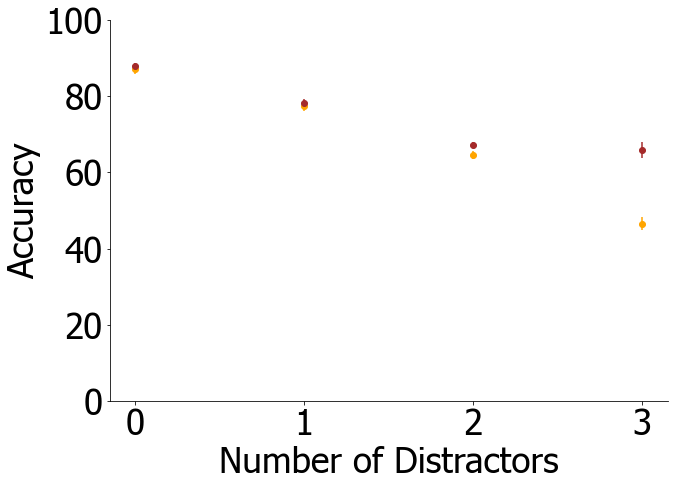

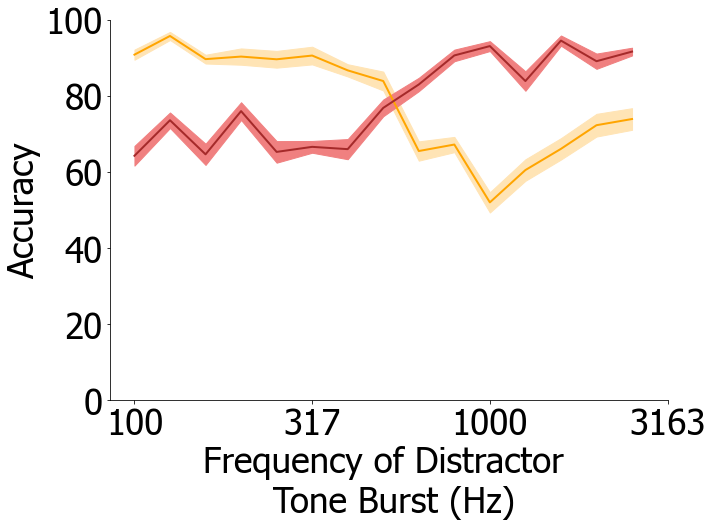

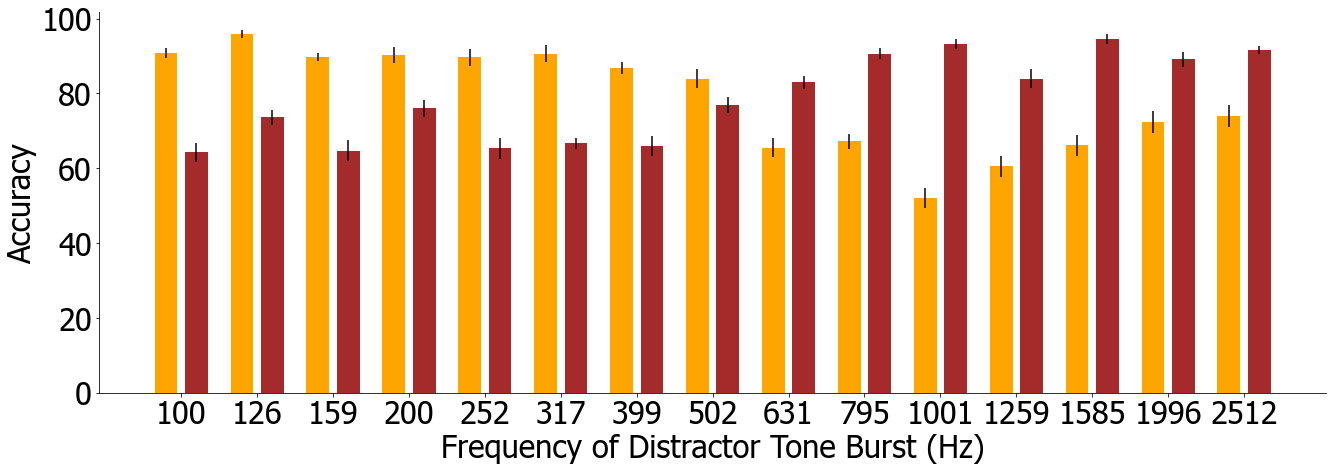

In [19]:
"""
Qs: First figure - how does performance vary with number and frequency of distractors?
"""
meanPerformance_lowCategory = np.array([87.09,77.38,64.61,46.53])
stdPerformance_lowCategory = np.array([9.11,9.65,8,12.9])
meanPerformance_highCategory = np.array([87.96,78.18,67.29,65.95])
stdPerformance_highCategory = np.array([6.48,7.93,5.87,15.32])

fig, ax1 = plt.subplots(1,1, figsize=(10,7))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
ax1.errorbar(np.arange(4),meanPerformance_lowCategory,
             yerr=stdPerformance_lowCategory/np.sqrt(56),
             color='orange',linestyle="None",marker='o')
ax1.errorbar(np.arange(4),meanPerformance_highCategory,
             yerr=stdPerformance_highCategory/np.sqrt(56),
             color='brown',linestyle="None",marker='o')
ax1.set_xlabel('Number of Distractors',fontsize=35)
ax1.set_ylabel('Accuracy',fontsize=35)
ax1.set_xticks([0,1,2,3])
ax1.set_xticklabels(['0','1','2','3'])
ax1.set_ylim(0,100)
ax1.tick_params(axis='both',labelsize=35)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
plt.savefig('figures/FromProlific/illustrations/PerformanceAccuracyInThePresenceOfDistractors_partI.eps',
            bbox_inches='tight',format='eps')

import pickle
with open('figures/FromProlific/illustrations/PerformanceAccuracyChangesWithFrequencyOfDistractor.pickle', 'rb') as handle:
    dict_behaviour = pickle.load(handle)
unique_distractors_low = dict_behaviour['unique_distractors_low']
averageBehaviorAcrossSubjects_low = dict_behaviour['averageBehaviorAcrossSubjects_low']
unique_distractors_high = dict_behaviour['unique_distractors_high']
averageBehaviorAcrossSubjects_high = dict_behaviour['averageBehaviorAcrossSubjects_high']
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.plot(unique_distractors_low, 
         np.mean(np.array(averageBehaviorAcrossSubjects_low)*100,axis=1),
         color='orange',linewidth=2)
ax.plot(unique_distractors_high, 
         np.mean(np.array(averageBehaviorAcrossSubjects_high)*100,axis=1),
         color='brown',linewidth=2)
ax.fill_between(unique_distractors_low, 
                 y1 = np.mean(np.array(averageBehaviorAcrossSubjects_low)*100,axis=1) - np.std(np.array(averageBehaviorAcrossSubjects_low)*100,axis=1)/np.sqrt(56),
                 y2 = np.mean(np.array(averageBehaviorAcrossSubjects_low)*100,axis=1) + np.std(np.array(averageBehaviorAcrossSubjects_low)*100,axis=1)/np.sqrt(56),
                 color='moccasin')
ax.fill_between(unique_distractors_high, 
                 y1 = np.mean(np.array(averageBehaviorAcrossSubjects_high)*100,axis=1) - np.std(np.array(averageBehaviorAcrossSubjects_high)*100,axis=1)/np.sqrt(56),
                 y2 = np.mean(np.array(averageBehaviorAcrossSubjects_high)*100,axis=1) + np.std(np.array(averageBehaviorAcrossSubjects_high)*100,axis=1)/np.sqrt(56),
                 color='lightcoral')
ax.set_xticks(np.array([2,2.5,3,3.5]))
ax.set_xticklabels(np.ceil([100,10**2.5,1000,10**3.5]).astype(int))
ax.set_ylim(0,100)
ax.set_xlabel('Frequency of Distractor \n Tone Burst (Hz)',fontsize=35)
ax.set_ylabel('Accuracy',fontsize=35)
ax.tick_params(axis='both',labelsize=35)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig, ax = plt.subplots(1,1, figsize=(22,7))
ax.bar(unique_distractors_low-0.02,np.mean(np.array(averageBehaviorAcrossSubjects_low)*100,axis=1),
       width=0.03,yerr=np.std(np.array(averageBehaviorAcrossSubjects_low)*100,axis=1)/np.sqrt(56),color='orange')
ax.bar(unique_distractors_high+0.02,np.mean(np.array(averageBehaviorAcrossSubjects_high)*100,axis=1),
       width=0.03,yerr=np.std(np.array(averageBehaviorAcrossSubjects_high)*100,axis=1)/np.sqrt(56),color='brown')
ax.set_xticks(np.arange(2,3.5,0.1))
ax.set_xticklabels(np.ceil(10**np.arange(2,3.5,0.1)).astype(int))
ax.set_xlabel('Frequency of Distractor Tone Burst (Hz)',fontsize=31)
ax.set_ylabel('Accuracy',fontsize=31)
ax.tick_params(axis='both',labelsize=31)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('figures/FromProlific/illustrations/PerformanceAccuracyInThePresenceOfDistractors_partII.eps',
            bbox_inches='tight',format='eps')

print("Correlation of low category accuracy with number of distractors", pg.corr(np.arange(4),
                                                                                meanPerformance_lowCategory,
                                                                                method = 'spearman'))
print("Correlation of high category accuracy with number of distractors", pg.corr(np.arange(4),
                                                                                meanPerformance_highCategory,
                                                                                method = 'spearman'))
print("Corelation of low category accuracy with distractor frequency", pg.corr(unique_distractors_low,
                                                                                np.mean(np.array(averageBehaviorAcrossSubjects_low)*100,axis=1),
                                                                                method = 'spearman'))
print("Corelation of high category accuracy with distractor frequency", pg.corr(unique_distractors_high,
                                                                                np.mean(np.array(averageBehaviorAcrossSubjects_high)*100,axis=1),
                                                                                method = 'spearman'))
print("Comparing central frequency using wilcoxon", pg.wilcoxon(averageBehaviorAcrossSubjects_low[8],
                                                                averageBehaviorAcrossSubjects_high[8]))
print("Comparing one frequency before center using wilcoxon", pg.wilcoxon(averageBehaviorAcrossSubjects_low[7],
                                                                            averageBehaviorAcrossSubjects_high[7]))
print("Comparing one frequency after center using wilcoxon", pg.wilcoxon(averageBehaviorAcrossSubjects_low[9],
                                                                            averageBehaviorAcrossSubjects_high[9]))
print("Comparing two frequencies before center using wilcoxon", pg.wilcoxon(averageBehaviorAcrossSubjects_low[6],
                                                                            averageBehaviorAcrossSubjects_high[6]))
print("Comparing two frequencies after center using wilcoxon", pg.wilcoxon(averageBehaviorAcrossSubjects_low[10],
                                                                            averageBehaviorAcrossSubjects_high[10]))
print("Median and iqr of central frequency accuracies", "low",
      np.median(averageBehaviorAcrossSubjects_low[10]),scipy.stats.iqr(averageBehaviorAcrossSubjects_low[10]),
      "high", np.median(averageBehaviorAcrossSubjects_high[10]),scipy.stats.iqr(averageBehaviorAcrossSubjects_high[10]))
print("Average accuracy for first 7 distractor tone frequencies", 
      np.nanmean(np.mean(np.array(averageBehaviorAcrossSubjects_low)*100,axis=1)[:8]),
      np.nanstd(np.mean(np.array(averageBehaviorAcrossSubjects_low)*100,axis=1)[:8])/np.sqrt(7))
print("Average accuracy for last 7 distractor tone frequencies", 
      np.nanmean(np.mean(np.array(averageBehaviorAcrossSubjects_low)*100,axis=1)[9:]),
      np.nanstd(np.mean(np.array(averageBehaviorAcrossSubjects_low)*100,axis=1)[9:])/np.sqrt(7))
print("Median Accuracy for low category trials",np.median(np.array(averageBehaviorAcrossSubjects_low)*100,axis=1))
print("Median Accuracy for high category trials",np.median(np.array(averageBehaviorAcrossSubjects_high)*100,axis=1))
print("IQR Accuracy for low category trials",scipy.stats.iqr(np.array(averageBehaviorAcrossSubjects_low)*100,axis=1))
print("IQR Accuracy for high category trials",scipy.stats.iqr(np.array(averageBehaviorAcrossSubjects_high)*100,axis=1))


0.185 0.14 0.28500000000000003 3 [29 34 35]


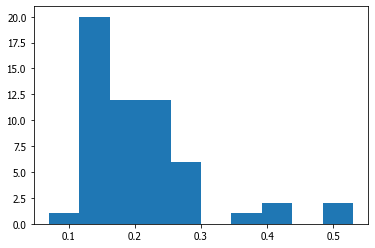

In [20]:
"""
Qs: Range of sigma sensory across the subject population. 
"""
indices = np.arange(56)
computedLikelihoods = pd.read_excel(xls,'NoContextModelFits')
sigmaSensory = computedLikelihoods['ss'].values
sigmaSensory = sigmaSensory[~numpy.isnan(sigmaSensory)]
plt.hist(sigmaSensory)
print(np.quantile(sigmaSensory, 0.5), np.quantile(sigmaSensory, 0.1), np.quantile(sigmaSensory, 0.90), 
      sum(sigmaSensory>np.quantile(sigmaSensory, 0.95)),indices[sigmaSensory>np.quantile(sigmaSensory, 0.95)])

-141.8330703447839 -398.48307034478387 -13.223070344783906
[ 7 19 40]
[23 34 35]
83.0
Median and IQR of random model BICs 844.5738593104322 0.0
Median and IQR of lesion model BICs 660.1346482760807 110.9899999999999
Median and IQR of signal model BICs 514.9915779312969 115.13
Comparing random and signal model BICs using wilcoxon           W-val alternative         p-val  RBC  CLES
Wilcoxon    0.0   two-sided  7.755146e-11  1.0   1.0
Comparing Lesion and signal model BICs using wilcoxon           W-val alternative         p-val  RBC     CLES
Wilcoxon    0.0   two-sided  7.755146e-11  1.0  0.87213
Comparing BIC signal to overall accuracy            n         r           CI95%         p-val  power
spearman  56 -0.850194  [-0.91, -0.76]  1.136169e-16    1.0
Median and IQR of one distractor tone trial accuracy 79.455 11.257500000000007
Median and IQR of two distractor tones trial accuracy 66.235 6.032499999999999


/Users/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


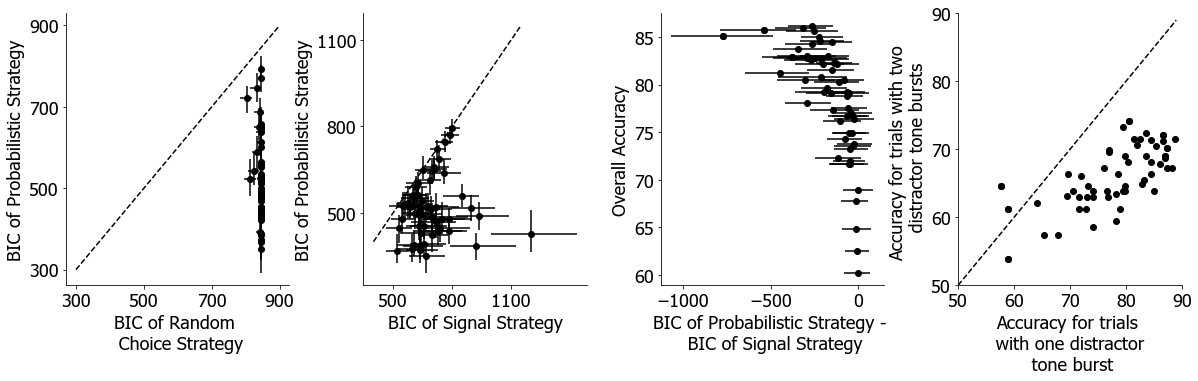

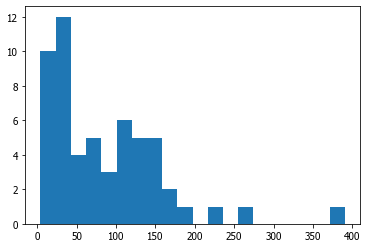

In [27]:
"""
Qs: Can we split participants up into two categories as a first pass? And then everybody else goes on a continuum.
"""

"""
The following variables are for bic values of the subsampled dataset.
"""
nll_subsampledData_signalModel = computedLikelihoods['medianFull'].values
nll_subsampledData_signalModel = nll_subsampledData_signalModel[~numpy.isnan(nll_subsampledData_signalModel)]

nll_subsampledData_lesionModel = computedLikelihoods['medianLesion'].values
nll_subsampledData_lesionModel = nll_subsampledData_lesionModel[~numpy.isnan(nll_subsampledData_lesionModel)]

nll_subsampledData_randomModel = computedLikelihoods['medianRandom'].values
nll_subsampledData_randomModel = nll_subsampledData_randomModel[~numpy.isnan(nll_subsampledData_randomModel)]

nll_subsampledData_votingModel = computedLikelihoods['medianVoting'].values
nll_subsampledData_votingModel = nll_subsampledData_votingModel[~numpy.isnan(nll_subsampledData_votingModel)]

nll_lowerErrorbars_signalModel = computedLikelihoods['5thPercentileFull'].values
nll_lowerErrorbars_signalModel = nll_lowerErrorbars_signalModel[~numpy.isnan(nll_lowerErrorbars_signalModel)]

nll_upperErrorbars_signalModel = computedLikelihoods['95thPercentileFull'].values
nll_upperErrorbars_signalModel = nll_upperErrorbars_signalModel[~numpy.isnan(nll_upperErrorbars_signalModel)]

nll_lowerErrorbars_lesionModel = computedLikelihoods['5thPercentileLesion'].values
nll_lowerErrorbars_lesionModel = nll_lowerErrorbars_lesionModel[~numpy.isnan(nll_lowerErrorbars_lesionModel)]

nll_upperErrorbars_lesionModel = computedLikelihoods['95thPercentileLesion'].values
nll_upperErrorbars_lesionModel = nll_upperErrorbars_lesionModel[~numpy.isnan(nll_upperErrorbars_lesionModel)]

nll_lowerErrorbars_randomModel = computedLikelihoods['5thPercentileRandom'].values
nll_lowerErrorbars_randomModel = nll_lowerErrorbars_randomModel[~numpy.isnan(nll_lowerErrorbars_randomModel)]

nll_upperErrorbars_randomModel = computedLikelihoods['95thPercentileRandom'].values
nll_upperErrorbars_randomModel = nll_upperErrorbars_randomModel[~numpy.isnan(nll_upperErrorbars_randomModel)]

nll_lowerErrorbars_votingModel = computedLikelihoods['5thPercentileVoting'].values
nll_lowerErrorbars_votingModel = nll_lowerErrorbars_votingModel[~numpy.isnan(nll_lowerErrorbars_votingModel)]

nll_upperErrorbars_votingModel = computedLikelihoods['95thPercentileVoting'].values
nll_upperErrorbars_votingModel = nll_upperErrorbars_votingModel[~numpy.isnan(nll_upperErrorbars_votingModel)]

"""
Qs: Where do subjects lie in the one irrelevant tone and two irrelevant tones space?
"""
performance = pd.read_excel(xls,'Strategy_PerformanceAccuracies',nrows = 57)
distractorPerformance = pd.read_excel(xls,'PerformanceVsNumDistractors',nrows=56)
OverallAccuracy = performance['OverallAccuracyNoContext'].values
OverallAccuracy = OverallAccuracy[~numpy.isnan(OverallAccuracy)]
OneIrrelevantToneAccuracy = np.ma.array(distractorPerformance['CombinedAcrossCategoriesOneDistractor'].values,mask=False)
TwoIrrelevantTonesAccuracy = np.ma.array(distractorPerformance['CombinedAcrossCategoriesTwoDistractors'].values,mask=False)

fig, (ax0,ax1,ax2,ax3) = plt.subplots(1,4,figsize=(20,5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.305, hspace=None)
for i in range(len(nll_subsampledData_signalModel)):
    ax0.errorbar(2*nll_subsampledData_randomModel[i]+2*np.log(600),
                 2*nll_subsampledData_signalModel[i]+6*np.log(600), 
                 xerr=[[-2*nll_lowerErrorbars_randomModel[i]+2*nll_subsampledData_randomModel[i]],
                      [2*nll_upperErrorbars_randomModel[i]-2*nll_subsampledData_randomModel[i]]],
                 yerr=[[-2*nll_lowerErrorbars_signalModel[i]+2*nll_subsampledData_signalModel[i]],
                      [2*nll_upperErrorbars_signalModel[i]-2*nll_subsampledData_signalModel[i]]],
                 color='k',marker='o')
    ax1.errorbar(2*nll_subsampledData_lesionModel[i]+5*np.log(600),
                 2*nll_subsampledData_signalModel[i]+6*np.log(600), 
                 xerr=[[-2*nll_lowerErrorbars_lesionModel[i]+2*nll_subsampledData_lesionModel[i]],
                      [2*nll_upperErrorbars_lesionModel[i]-2*nll_subsampledData_lesionModel[i]]],
                 yerr=[[-2*nll_lowerErrorbars_signalModel[i]+2*nll_subsampledData_signalModel[i]],
                      [2*nll_upperErrorbars_signalModel[i]-2*nll_subsampledData_signalModel[i]]],
                 color='k',marker='o')
    if i in [19,36,40]:
        ax2.errorbar(-2*nll_subsampledData_lesionModel[i]-5*np.log(600)
                     +2*nll_subsampledData_signalModel[i]+6*np.log(600), 
                     OverallAccuracy[i],
                     xerr=[[2*nll_upperErrorbars_lesionModel[i]-2*nll_lowerErrorbars_signalModel[i]
                           -2*nll_subsampledData_lesionModel[i]+2*nll_subsampledData_signalModel[i]],
                           [-2*nll_lowerErrorbars_lesionModel[i]+2*nll_upperErrorbars_signalModel[i]
                           +2*nll_subsampledData_lesionModel[i]-2*nll_subsampledData_signalModel[i]]],
                     color='k',marker='o',ecolor='k') 
    elif i in [29,34,35]: 
        ax2.errorbar(-2*nll_subsampledData_lesionModel[i]-5*np.log(600)
                     +2*nll_subsampledData_signalModel[i]+6*np.log(600), 
                     OverallAccuracy[i],
                     xerr=[[2*nll_upperErrorbars_lesionModel[i]-2*nll_lowerErrorbars_signalModel[i]
                           -2*nll_subsampledData_lesionModel[i]+2*nll_subsampledData_signalModel[i]],
                           [-2*nll_lowerErrorbars_lesionModel[i]+2*nll_upperErrorbars_signalModel[i]
                           +2*nll_subsampledData_lesionModel[i]-2*nll_subsampledData_signalModel[i]]],
                     color='k',marker='o',ecolor='k')       
    else:
        ax2.errorbar(-2*nll_subsampledData_lesionModel[i]-5*np.log(600)
                     +2*nll_subsampledData_signalModel[i]+6*np.log(600), 
                     OverallAccuracy[i],
                     xerr=[[2*nll_upperErrorbars_lesionModel[i]-2*nll_lowerErrorbars_signalModel[i]
                           -2*nll_subsampledData_lesionModel[i]+2*nll_subsampledData_signalModel[i]],
                           [-2*nll_lowerErrorbars_lesionModel[i]+2*nll_upperErrorbars_signalModel[i]
                           +2*nll_subsampledData_lesionModel[i]-2*nll_subsampledData_signalModel[i]]],
                     color='k',marker='o')

    

ax0.plot(np.arange(300,900),np.arange(300,900),'k--')
ax0.set_xticks([300,500,700,900]); ax0.set_yticks([300,500,700,900])
ax1.plot(np.arange(400,1150),np.arange(400,1150),'k--')
ax1.set_xticks([500,800,1100]); ax1.set_yticks([500,800,1100])
ax2.plot(- 2*nll_subsampledData_lesionModel[[36,40,19]] - 5*np.log(600)
         + 2*nll_subsampledData_signalModel[[36,40,19]] + 6*np.log(600),
         OverallAccuracy[[36,40,19]],'ko')
ax3.plot(OneIrrelevantToneAccuracy,TwoIrrelevantTonesAccuracy,'ko')
ax3.plot(OneIrrelevantToneAccuracy[[40,19,36]],TwoIrrelevantTonesAccuracy[[40,19,36]],'ko')
ax3.plot(OneIrrelevantToneAccuracy[[29,34,35]],TwoIrrelevantTonesAccuracy[[29,34,35]],
         marker='o',linestyle='None',color='k')
ax3.set_xlim([50,90])
ax3.set_ylim([50,90])
ax3.plot(np.arange(50,90),np.arange(50,90),'k--')

ax0.set_xlabel('BIC of Random \n Choice Strategy', fontsize=18)
ax0.set_ylabel('BIC of Probabilistic Strategy',fontsize=18)
ax0.tick_params(axis='both',labelsize=18)
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)

ax1.set_xlabel('BIC of Signal Strategy', fontsize=18)
ax1.set_ylabel('BIC of Probabilistic Strategy',fontsize=18)
ax1.tick_params(axis='both',labelsize=18)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2.set_xlabel('BIC of Probabilistic Strategy - \n BIC of Signal Strategy', fontsize=18)
ax2.set_ylabel('Overall Accuracy',fontsize=18)
ax2.tick_params(axis='both',labelsize=18)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax3.set_xlabel('Accuracy for trials \n with one distractor \n tone burst',fontsize=18)
ax3.set_ylabel('Accuracy for trials with two \n distractor tone bursts',fontsize=18)
ax3.tick_params(axis='both',labelsize=18)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
plt.subplots_adjust(wspace=0.33)
plt.savefig('figures/FromProlific/illustrations/comparingBICAcrossStrategyLesionvsFull.eps',bbox_inches="tight")

"""
Qs: what is the distribution of the bic values of the subjects?
"""
plt.figure()
plt.hist(nll_subsampledData_lesionModel-nll_subsampledData_signalModel,bins=20)
print(np.quantile(-2*nll_subsampledData_lesionModel-5*np.log(600)+2*nll_subsampledData_signalModel+6*np.log(600), 0.5), 
      np.quantile(-2*nll_subsampledData_lesionModel-5*np.log(600)+2*nll_subsampledData_signalModel+6*np.log(600), 0.05), 
      np.quantile(-2*nll_subsampledData_lesionModel-5*np.log(600)+2*nll_subsampledData_signalModel+6*np.log(600), 0.95))
print(indices[-2*nll_subsampledData_lesionModel-5*np.log(600)+2*nll_subsampledData_signalModel+6*np.log(600)<
      np.quantile(-2*nll_subsampledData_lesionModel-5*np.log(600)+2*nll_subsampledData_signalModel+6*np.log(600), 0.05)])
print(indices[-2*nll_subsampledData_lesionModel-5*np.log(600)+2*nll_subsampledData_signalModel+6*np.log(600)>
      np.quantile(-2*nll_subsampledData_lesionModel-5*np.log(600)+2*nll_subsampledData_signalModel+6*np.log(600), 0.95)])
print(np.quantile(OverallAccuracy,0.80))

"""
fig, [ax1,ax3] = plt.subplots(1,2,figsize=(15,5))
for i in range(len(nll_subsampledData_votingModel)):
    if i not in [23, 34, 35,  4, 29]:
        if i in [3,40,36,10]:
            ax1.errorbar(2*nll_subsampledData_votingModel[i]+5*np.log(500),
                         2*nll_subsampledData_signalModel[i]+6*np.log(500),
                         xerr=[[-2*nll_lowerErrorbars_votingModel[i]+2*nll_subsampledData_votingModel[i]],
                              [2*nll_upperErrorbars_votingModel[i]-2*nll_subsampledData_votingModel[i]]],
                         yerr=[[-2*nll_lowerErrorbars_signalModel[i]+2*nll_subsampledData_signalModel[i]],
                              [2*nll_upperErrorbars_signalModel[i]-2*nll_subsampledData_signalModel[i]]],
                         ecolor='red',color='red',marker='o',linestyle='None')

        elif i == 28:
            ax1.errorbar(2*nll_subsampledData_votingModel[i]+5*np.log(500),
                         2*nll_subsampledData_signalModel[i]+6*np.log(500),
                         xerr=[[-2*nll_lowerErrorbars_votingModel[i]+2*nll_subsampledData_votingModel[i]],
                              [2*nll_upperErrorbars_votingModel[i]-2*nll_subsampledData_votingModel[i]]],
                         yerr=[[-2*nll_lowerErrorbars_signalModel[i]+2*nll_subsampledData_signalModel[i]],
                              [2*nll_upperErrorbars_signalModel[i]-2*nll_subsampledData_signalModel[i]]],
                         ecolor='limegreen',color='limegreen',marker='o',linestyle='None')
        else:
            ax1.errorbar(2*nll_subsampledData_votingModel[i]+5*np.log(500),
                         2*nll_subsampledData_signalModel[i]+6*np.log(500), 
                         xerr=[[-2*nll_lowerErrorbars_votingModel[i]+2*nll_subsampledData_votingModel[i]],
                              [2*nll_upperErrorbars_votingModel[i]-2*nll_subsampledData_votingModel[i]]],
                         yerr=[[-2*nll_lowerErrorbars_signalModel[i]+2*nll_subsampledData_signalModel[i]],
                              [2*nll_upperErrorbars_signalModel[i]-2*nll_subsampledData_signalModel[i]]],
                         color='k',marker='.')
            
ax1.plot(np.arange(270,620),np.arange(270,620),'k--')  
ax1.set_xlabel('BIC of Voting Strategy', fontsize=17)
ax1.set_ylabel('BIC of Signal Strategy',fontsize=17)
ax1.tick_params(axis='both',labelsize=17)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax3.plot(OneIrrelevantToneAccuracy,TwoIrrelevantTonesAccuracy, marker='.',linestyle='None',color='black')
ax3.plot(OneIrrelevantToneAccuracy[[3,40,36,10]],TwoIrrelevantTonesAccuracy[[3,40,36,10]],'ro')
ax3.plot(OneIrrelevantToneAccuracy[[28]],TwoIrrelevantTonesAccuracy[[28]],
         marker='o',linestyle='None',color='limegreen')
ax3.set_xlabel('Accuracy for trials with one \n distractor experimental tone',fontsize=17)
ax3.set_ylabel('Accuracy for trials with two \n distractor experimental tones',fontsize=17)
ax3.tick_params(axis='both',labelsize=17)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
#plt.savefig('figures/FromProlific/illustrations/comparingBICAcrossStrategyVotingvsFull.eps',bbox_inches="tight")
"""

print("Median and IQR of random model BICs",np.median(2*nll_subsampledData_randomModel+2*np.log(600)),
      scipy.stats.iqr(2*nll_subsampledData_randomModel+2*np.log(600)))

print("Median and IQR of lesion model BICs",np.median(2*nll_subsampledData_lesionModel+5*np.log(600)),
      scipy.stats.iqr(2*nll_subsampledData_lesionModel+5*np.log(600)))

print("Median and IQR of signal model BICs",np.median(2*nll_subsampledData_signalModel+6*np.log(600)),
      scipy.stats.iqr(2*nll_subsampledData_signalModel+6*np.log(600)))

print("Comparing random and signal model BICs using wilcoxon", pg.wilcoxon(2*nll_subsampledData_randomModel+2*np.log(600),
                                                                           2*nll_subsampledData_signalModel+6*np.log(600)))
print("Comparing Lesion and signal model BICs using wilcoxon", pg.wilcoxon(2*nll_subsampledData_lesionModel+5*np.log(600),
                                                                           2*nll_subsampledData_signalModel+6*np.log(600)))
#print("Comparing voting and signal model BICs using wilcoxon", pg.wilcoxon(2*nll_subsampledData_votingModel+5*np.log(500),
#                                                                           2*nll_subsampledData_signalModel+6*np.log(600)))
print("Comparing BIC signal to overall accuracy",pg.corr(2*nll_subsampledData_signalModel-2*nll_subsampledData_lesionModel+np.log(600),
                                                         OverallAccuracy,method='spearman'))

OneIrrelevantToneAccuracy.mask[[29,34]]=True
TwoIrrelevantTonesAccuracy.mask[[29,34]]=True
print("Median and IQR of one distractor tone trial accuracy",np.median(OneIrrelevantToneAccuracy),
     scipy.stats.iqr(OneIrrelevantToneAccuracy))
print("Median and IQR of two distractor tones trial accuracy",np.median(TwoIrrelevantTonesAccuracy),
     scipy.stats.iqr(TwoIrrelevantTonesAccuracy))



Sigma sensory mean is 0.20910714285714288 and standard deviation is 0.08978698572801322
Subjects with high sigma sensory are [[ 4]
 [23]
 [29]
 [34]
 [35]]
Correlation of pback with accuracies
           n         r          CI95%     p-val     power
spearman  56  0.106758  [-0.16, 0.36]  0.433555  0.122954
           n         r         CI95%     p-val     power
spearman  56  0.038851  [-0.23, 0.3]  0.776192  0.059079
           n         r          CI95%         p-val     power
spearman  56 -0.685749  [-0.8, -0.52]  5.483892e-09  0.999987
           n        r           CI95%         p-val     power
spearman  56 -0.71929  [-0.83, -0.56]  4.238841e-10  0.999999
           n        r          CI95%     p-val     power
spearman  56  0.08022  [-0.19, 0.34]  0.556722  0.090403
           n         r           CI95%         p-val  power
spearman  56 -0.772419  [-0.86, -0.64]  3.124326e-12    1.0


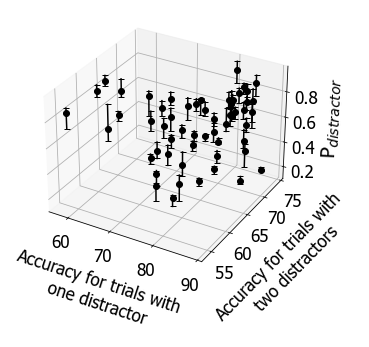

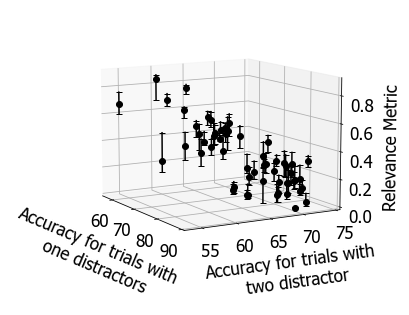

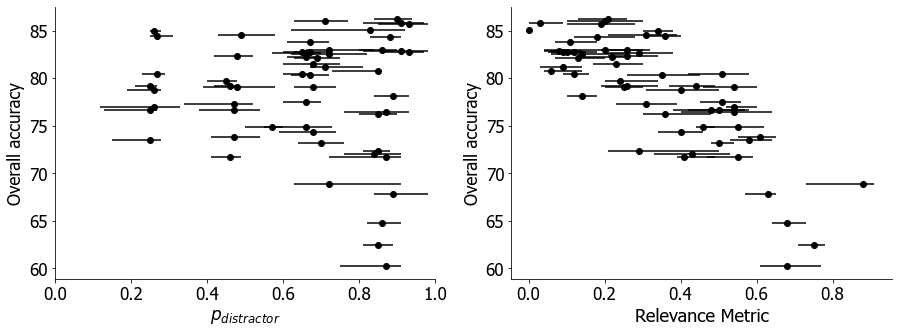

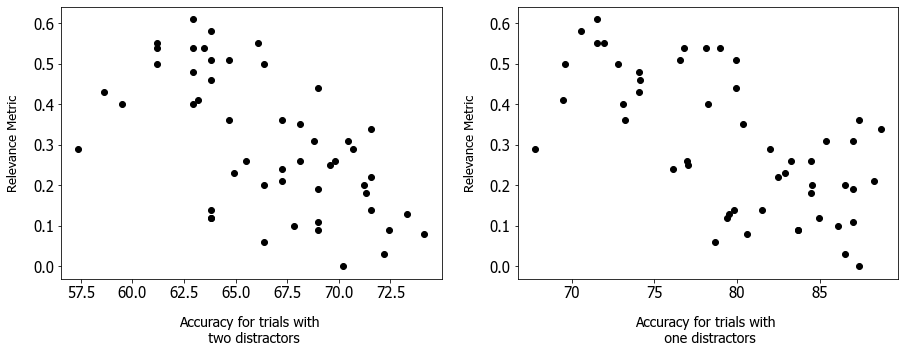

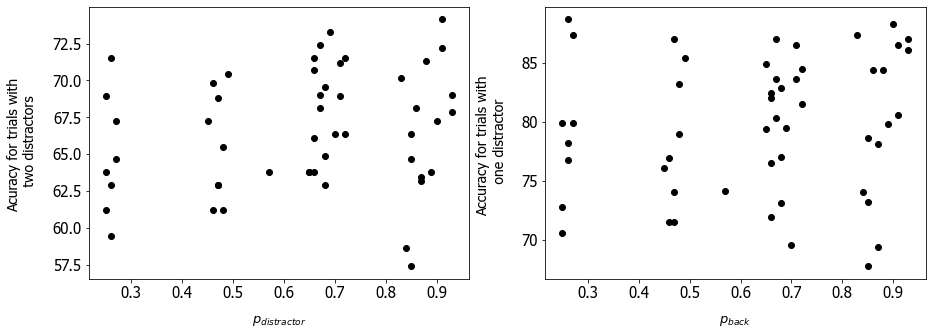

In [28]:
"""
Figure 4.
Qs: how can we relate performance to metrics from the bayesian model?
"""
pbackCalcuatedOnSubsampledDataset = computedLikelihoods['medianPBack'].values
pbackLowerErrorBars = computedLikelihoods['5thPercentilePBack'].values
pbackUpperErrorBars = computedLikelihoods['95thPercentilePBack'].values
pbackCalcuatedOnSubsampledDataset = pbackCalcuatedOnSubsampledDataset[~numpy.isnan(pbackCalcuatedOnSubsampledDataset)]
pbackLowerErrorBars = pbackLowerErrorBars[~numpy.isnan(pbackLowerErrorBars)]
pbackUpperErrorBars = pbackUpperErrorBars[~numpy.isnan(pbackUpperErrorBars)]

posteriorNorm = computedLikelihoods['medianRelevanceMetric'].values
posteriorNorm = posteriorNorm[~numpy.isnan(posteriorNorm)]
posteriorNormLowerErrorBars = computedLikelihoods['5thPercentileRelevanceMetric'].values
posteriorNormLowerErrorBars = posteriorNormLowerErrorBars[~numpy.isnan(posteriorNormLowerErrorBars)]
posteriorNormUpperErrorBars = computedLikelihoods['95thPercentileRelevanceMetric'].values
posteriorNormUpperErrorBars = posteriorNormUpperErrorBars[~numpy.isnan(posteriorNormUpperErrorBars)]

print(f"Sigma sensory mean is {np.mean(sigmaSensory)} and standard deviation is {np.std(sigmaSensory)}")
print(f"Subjects with high sigma sensory are {np.argwhere(sigmaSensory>np.mean(sigmaSensory)+np.std(sigmaSensory))}")

OneIrrelevantToneAccuracy.mask[[29,34]]=False
TwoIrrelevantTonesAccuracy.mask[[29,34]]=False

plt.figure(figsize=(10,5))
ax = plt.axes(projection='3d')
for iSubj in range(len(pbackCalcuatedOnSubsampledDataset)):
    ax.plot3D(OneIrrelevantToneAccuracy[iSubj],TwoIrrelevantTonesAccuracy[iSubj],
            pbackCalcuatedOnSubsampledDataset[iSubj],'ko')
    ax.plot([OneIrrelevantToneAccuracy[iSubj],OneIrrelevantToneAccuracy[iSubj]],
            [TwoIrrelevantTonesAccuracy[iSubj],TwoIrrelevantTonesAccuracy[iSubj]],
            [pbackLowerErrorBars[iSubj], pbackUpperErrorBars[iSubj]],marker="_", color='k')
ax.set_xlabel('Accuracy for trials with \n one distractor',fontsize=17,labelpad=19)
ax.set_ylabel('Accuracy for trials with \n two distractors',fontsize=17,labelpad=19)
ax.set_zlabel('P$_{distractor}$',fontsize=20, labelpad=8)
ax.tick_params(axis='both',labelsize=17)
#ax.view_init(10, -60)
plt.savefig('figures/FromProlific/illustrations/irrelevantToneAccuracyGivenPback.png',bbox_inches="tight")

plt.figure(figsize=(10,5))
ax = plt.axes(projection='3d')
for iSubj in range(len(posteriorNorm)):
    ax.plot3D(OneIrrelevantToneAccuracy[iSubj],TwoIrrelevantTonesAccuracy[iSubj],
              posteriorNorm[iSubj],'ko')
    ax.plot([OneIrrelevantToneAccuracy[iSubj],OneIrrelevantToneAccuracy[iSubj]],
            [TwoIrrelevantTonesAccuracy[iSubj],TwoIrrelevantTonesAccuracy[iSubj]],
            [posteriorNormLowerErrorBars[iSubj], posteriorNormUpperErrorBars[iSubj]],marker="_", color='k')
ax.set_xlabel('Accuracy for trials with \n one distractors',fontsize=17,labelpad=19)
ax.set_ylabel('Accuracy for trials with \n two distractor',fontsize=17,labelpad=21)
ax.set_zlabel('Relevance Metric',fontsize=17, labelpad=8)
ax.tick_params(axis='both',labelsize=17)
ax.view_init(10, -30)
plt.savefig('figures/FromProlific/illustrations/irrelevantToneAccuracyGivenPosteriorShape.png',bbox_inches="tight")

fig, [ax1,ax2] = plt.subplots(1,2,figsize=(15,5))
for iSubj in range(len(posteriorNorm)):
    ax1.errorbar(pbackCalcuatedOnSubsampledDataset[iSubj],OverallAccuracy[iSubj],
                xerr=[[-pbackLowerErrorBars[iSubj]+pbackCalcuatedOnSubsampledDataset[iSubj]],
                      [pbackUpperErrorBars[iSubj]-pbackCalcuatedOnSubsampledDataset[iSubj]]],
                 color='k',marker='o')
    ax2.errorbar(posteriorNorm[iSubj],OverallAccuracy[iSubj],
                xerr=[[-posteriorNormLowerErrorBars[iSubj]+posteriorNorm[iSubj]],
                      [posteriorNormUpperErrorBars[iSubj]-posteriorNorm[iSubj]]],
                 color='k',marker='o')
ax1.set_xlim([0,1])
ax1.set_xlabel(r'$p_{distractor}$',fontsize=17)
ax1.set_ylabel('Overall accuracy',fontsize=17)
ax1.tick_params(axis='both',labelsize=17)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.set_xlabel('Relevance Metric',fontsize=18)
ax2.set_ylabel('Overall accuracy',fontsize=17)
ax2.tick_params(axis='both',labelsize=17)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
plt.savefig('figures/FromProlific/illustrations/overallAccuracyGivenPbackAndPosteriorShape.eps',bbox_inches="tight")

print("Correlation of pback with accuracies")
print(pg.corr(pbackCalcuatedOnSubsampledDataset,TwoIrrelevantTonesAccuracy,method='spearman'))
print(pg.corr(pbackCalcuatedOnSubsampledDataset,OneIrrelevantToneAccuracy,method='spearman'))
print(pg.corr(posteriorNorm,TwoIrrelevantTonesAccuracy,method='spearman'))
print(pg.corr(posteriorNorm,OneIrrelevantToneAccuracy,method='spearman'))
print(pg.corr(pbackCalcuatedOnSubsampledDataset,OverallAccuracy,method='spearman'))
print(pg.corr(posteriorNorm,OverallAccuracy,method='spearman'))

fig, [ax1,ax2] = plt.subplots(1,2,figsize=(15,5))
for iSubj in range(len(posteriorNorm)):
    if iSubj not in [4,23,29,34,35]:
        ax1.plot(TwoIrrelevantTonesAccuracy[iSubj],posteriorNorm[iSubj],'ko')
        ax2.plot(OneIrrelevantToneAccuracy[iSubj],posteriorNorm[iSubj],'ko')
ax1.set_xlabel('Accuracy for trials with \n two distractors',fontsize=14,labelpad=15)
ax2.set_xlabel('Accuracy for trials with \n one distractors',fontsize=14,labelpad=15)
ax1.set_ylabel('Relevance Metric',fontsize=13, labelpad=13)
ax2.set_ylabel('Relevance Metric',fontsize=13, labelpad=13)
ax1.tick_params(axis='both',labelsize=15)
ax2.tick_params(axis='both',labelsize=15)

fig, [ax1,ax2] = plt.subplots(1,2,figsize=(15,5))
for iSubj in range(len(posteriorNorm)):
    if iSubj not in [4,23,29,34,35]:
        ax1.plot(pbackCalcuatedOnSubsampledDataset[iSubj],TwoIrrelevantTonesAccuracy[iSubj],'ko')
        ax2.plot(pbackCalcuatedOnSubsampledDataset[iSubj],OneIrrelevantToneAccuracy[iSubj],'ko')
ax1.set_ylabel('Acuracy for trials with \n two distractors',fontsize=14,labelpad=15)
ax2.set_ylabel('Accuracy for trials with \n one distractor',fontsize=14,labelpad=15)
ax1.set_xlabel(r'$p_{distractor}$',
              fontsize=13, labelpad=13)
ax2.set_xlabel(r'$p_{back}$',
              fontsize=13, labelpad=13)
ax1.tick_params(axis='both',labelsize=15)
ax2.tick_params(axis='both',labelsize=15)

#plt.savefig('figures/FromProlific/illustrations/irrelevantToneAccuracyGivenPosteriorShape.eps',bbox_inches="tight")



Median of internalized bias in the unbiased session for bias low subjects 0.0 0.08000000000000007
Median of internalized bias in the unbiased session for bias high subjects 0.0 0.08000000000000007
Median of internalized bias in the biased low session 0.09999999999999998 0.12
Median of internalized bias in the biased high session 0.19999999999999996 0.1700000000000001
Comparing bias in no and low sessions           W-val alternative         p-val       RBC     CLES
Wilcoxon   42.5   two-sided  6.092451e-09 -0.935897  0.11214
Comparing bias in no and high sessions           W-val alternative         p-val  RBC      CLES
Wilcoxon    0.0   two-sided  3.623176e-09 -1.0  0.036892
Correlation of bias with difference in accuracy in biased low session            n         r        CI95%         p-val  power
spearman  53  0.993901  [0.99, 1.0]  1.643448e-50    1.0
Correlation of bias with difference in accuracy in biased high session            n         r         CI95%         p-val  power
spea

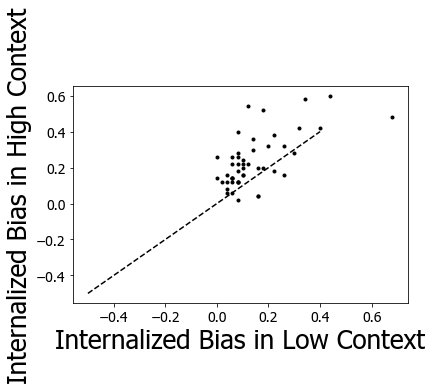

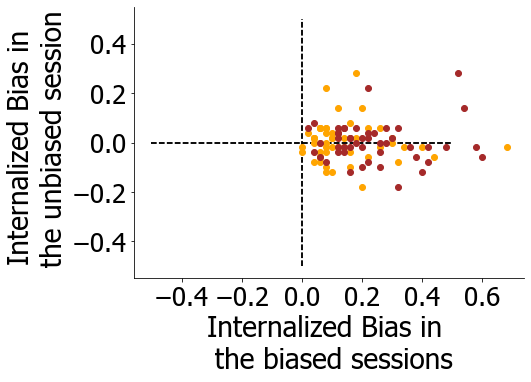

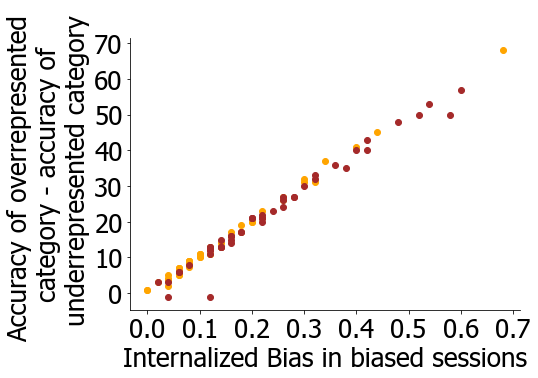

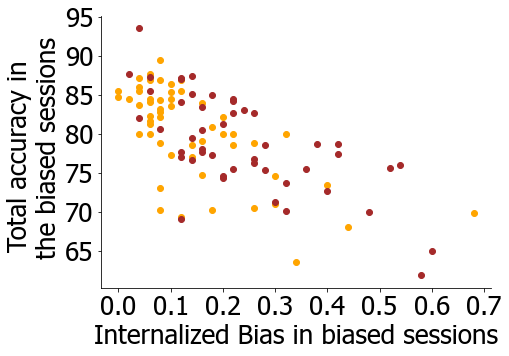

In [23]:
"""
Figure 5.
"""
"""
Qs: are subjects equally biased in both the long context cases? 
This is the internalized bias which is obtained from the matched raw data for subjects that do both the long 
context expts.
"""
internalizedBias = pd.read_excel(xls,'internalizedBias',nrows=53)

biasLowForSubjectsWithBothLongContexts = internalizedBias['biasLowContext']
biasLowForSubjectsWithBothLongContexts = biasLowForSubjectsWithBothLongContexts[~numpy.isnan(internalizedBias['biasHighContext'])]
biasHighForSubjectsWithBothLongContexts = internalizedBias['biasHighContext']
biasHighForSubjectsWithBothLongContexts = biasHighForSubjectsWithBothLongContexts[~numpy.isnan(biasHighForSubjectsWithBothLongContexts)]

fig, ax = plt.subplots()
ax.plot((0.5-biasLowForSubjectsWithBothLongContexts)*2,(biasHighForSubjectsWithBothLongContexts-0.5)*2,'k.')
ax.plot(np.arange(-0.5,0.5,0.1),np.arange(-0.5,0.5,0.1),'k--')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Internalized Bias in Low Context',fontsize=26)
plt.ylabel('Internalized Bias in High Context',fontsize=26)
#plt.savefig('figures/FromProlific/illustrations/biasLowContextVsbiasHighContext',bbox_inches="tight")

"""
Qs: are subjects also biased in the no context case? This is benchmarking internalized bias against 
the no context.  
"""

biasLowForSubjectsWithNoAndLowContexts = internalizedBias['biasLowContext']
biasLowForSubjectsWithNoAndLowContexts = biasLowForSubjectsWithNoAndLowContexts[~numpy.isnan(biasLowForSubjectsWithNoAndLowContexts)]
biasNoForSubjectsWithNoAndLowContexts = internalizedBias['biasNoContext']
biasNoForSubjectsWithNoAndLowContexts = biasNoForSubjectsWithNoAndLowContexts[~numpy.isnan(internalizedBias['biasLowContext'])]

fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.plot((0.5-biasLowForSubjectsWithNoAndLowContexts)*2,(biasNoForSubjectsWithNoAndLowContexts-0.5)*2,'o',color='orange')
ax.hlines(0,xmin=-0.5,xmax=0.5,color='k',linestyles='--')
ax.vlines(0,ymin=-0.5,ymax=0.5,color='k',linestyles='--')

biasHighForSubjectsWithNoAndHighContexts = internalizedBias['biasHighContext']
biasHighForSubjectsWithNoAndHighContexts = biasHighForSubjectsWithNoAndHighContexts[~numpy.isnan(biasHighForSubjectsWithNoAndHighContexts)]
biasNoForSubjectsWithNoAndHighContexts = internalizedBias['biasNoContext']
biasNoForSubjectsWithNoAndHighContexts = biasNoForSubjectsWithNoAndHighContexts[~numpy.isnan(internalizedBias['biasHighContext'])]

ax.plot((biasHighForSubjectsWithNoAndHighContexts-0.5)*2,(biasNoForSubjectsWithNoAndHighContexts-0.5)*2,'o',color='brown')
ax.hlines(0,xmin=-0.5,xmax=0.5,color='k',linestyles='--')
ax.vlines(0,ymin=-0.5,ymax=0.5,color='k',linestyles='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.xlabel('Internalized Bias in \n the biased sessions',fontsize=28)
plt.ylabel('Internalized Bias in \n the unbiased session',fontsize=28)
plt.savefig('figures/FromProlific/illustrations/biasNoContextVsbiasLongContext.eps',bbox_inches="tight")

"""
Qs: how does internalized bias compare to performance accuracy?
"""
biasHighForAllSubjectsWithHighContext = internalizedBias['biasHighContext'].values
biasHighForAllSubjectsWithHighContext = biasHighForAllSubjectsWithHighContext[~numpy.isnan(internalizedBias['biasHighContext'])]
majorityVsMinorityCategoryAccuracyHighContext = internalizedBias['DifferenceInAccuracyOfCategoriesInHighContext']
majorityVsMinorityCategoryAccuracyHighContext = majorityVsMinorityCategoryAccuracyHighContext[~numpy.isnan(majorityVsMinorityCategoryAccuracyHighContext)]

biasLowForAllSubjectsWithLowContext = internalizedBias['biasLowContext'].values
majorityVsMinorityCategoryAccuracyLowContext = internalizedBias['DifferenceInAccuracyOfCategoriesInLowContext']

fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.plot((0.5-biasLowForSubjectsWithNoAndLowContexts)*2,majorityVsMinorityCategoryAccuracyLowContext*100,
        'o',color='orange')
ax.plot((biasHighForSubjectsWithNoAndHighContexts-0.5)*2,majorityVsMinorityCategoryAccuracyHighContext*100,
        'o',color='brown')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.arange(0,0.8,0.1))
ax.set_xticklabels(np.around(np.arange(0,0.8,0.1),1),fontsize=26)
plt.yticks(fontsize=26)
plt.xlabel('Internalized Bias in biased sessions',fontsize=26)
plt.ylabel('Accuracy of overrepresented \n category - accuracy of \n underrepresented category',fontsize=26)
plt.savefig('figures/FromProlific/illustrations/accuracyInMajorityMinorityCategoriesExplainsInternalisedBias.eps',
            bbox_inches="tight")

AccuracyHighContext = internalizedBias['accuracyHighContext']
AccuracyHighContext = AccuracyHighContext[~numpy.isnan(AccuracyHighContext)]
AccuracyLowContext = internalizedBias['accuracyLowContext']

fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.plot((0.5-biasLowForSubjectsWithNoAndLowContexts)*2,AccuracyLowContext,
        'o',color='orange')
ax.plot((biasHighForSubjectsWithNoAndHighContexts-0.5)*2,AccuracyHighContext,
        'o',color='brown')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.arange(0,0.8,0.1))
ax.set_xticklabels(np.around(np.arange(0,0.8,0.1),1),fontsize=26)
plt.yticks(fontsize=26)
plt.xlabel('Internalized Bias in biased sessions',fontsize=26)
plt.ylabel('Total accuracy in \n the biased sessions',fontsize=26)
plt.savefig('figures/FromProlific/illustrations/totalAccuracyVsInternalisedBias.eps',
            bbox_inches="tight")

print("Median of internalized bias in the unbiased session for bias low subjects", 
      np.median((0.5-biasNoForSubjectsWithNoAndLowContexts)*2), 
      scipy.stats.iqr((0.5-biasNoForSubjectsWithNoAndLowContexts)*2))
print("Median of internalized bias in the unbiased session for bias high subjects", 
      np.median((0.5-biasNoForSubjectsWithNoAndHighContexts)*2), 
      scipy.stats.iqr((0.5-biasNoForSubjectsWithNoAndHighContexts)*2))
print("Median of internalized bias in the biased low session", 
      np.median((0.5-biasLowForSubjectsWithNoAndLowContexts)*2),
      scipy.stats.iqr((0.5-biasLowForSubjectsWithNoAndLowContexts)*2))
print("Median of internalized bias in the biased high session", 
     np.median((biasHighForSubjectsWithNoAndHighContexts-0.5)*2), 
      scipy.stats.iqr((biasHighForSubjectsWithNoAndHighContexts-0.5)*2))
print("Comparing bias in no and low sessions",pg.wilcoxon((0.5-biasNoForSubjectsWithNoAndLowContexts)*2,
                                                          (0.5-biasLowForSubjectsWithNoAndLowContexts)*2))
print("Comparing bias in no and high sessions",pg.wilcoxon((0.5-biasNoForSubjectsWithNoAndHighContexts)*2,
                                                           (biasHighForSubjectsWithNoAndHighContexts-0.5)*2))
print("Correlation of bias with difference in accuracy in biased low session",
      pg.corr((0.5-biasLowForSubjectsWithNoAndLowContexts)*2,
              majorityVsMinorityCategoryAccuracyLowContext,method='spearman'))
print("Correlation of bias with difference in accuracy in biased high session",
      pg.corr((biasHighForSubjectsWithNoAndHighContexts-0.5)*2,
              majorityVsMinorityCategoryAccuracyHighContext,method='spearman'))
print("Correlation of bias and accuracy in biased low session", pg.corr((0.5-biasLowForSubjectsWithNoAndLowContexts)*2,
                                                                        AccuracyLowContext,method='spearman'))
print("Correlation of bias and accuracy in biased high session", pg.corr((biasHighForSubjectsWithNoAndHighContexts-0.5)*2,
                                                                         AccuracyHighContext,method='spearman'))


/Users/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Median and IQR of random model BICs low context 663.8654653894082 13.180000000000064
Median and IQR of random model BICs high context 629.0024529789663 35.514999999999986
Median and IQR of lesion model BICs low context 547.4448949279277 87.80000000000001
Median and IQR of lesion model BICs high context 529.2261324474157 108.84000000000015
Median and IQR of signal model BICs low context 412.2508097755059 135.97452225471125
Median and IQR of signal model BICs high context 430.1773589368988 141.12118265097075
Comparing random and signal model BICs low context using wilcoxon           W-val alternative         p-val       RBC      CLES
Wilcoxon  106.0   two-sided  6.993668e-08  0.851852  0.936276
Comparing random and signal model BICs high context using wilcoxon           W-val alternative         p-val  RBC      CLES
Wilcoxon    0.0   two-sided  3.641591e-09  1.0  0.946615
Comparing Lesion and signal model BICs low context using wilcoxon           W-val alternative         p-val       RBC

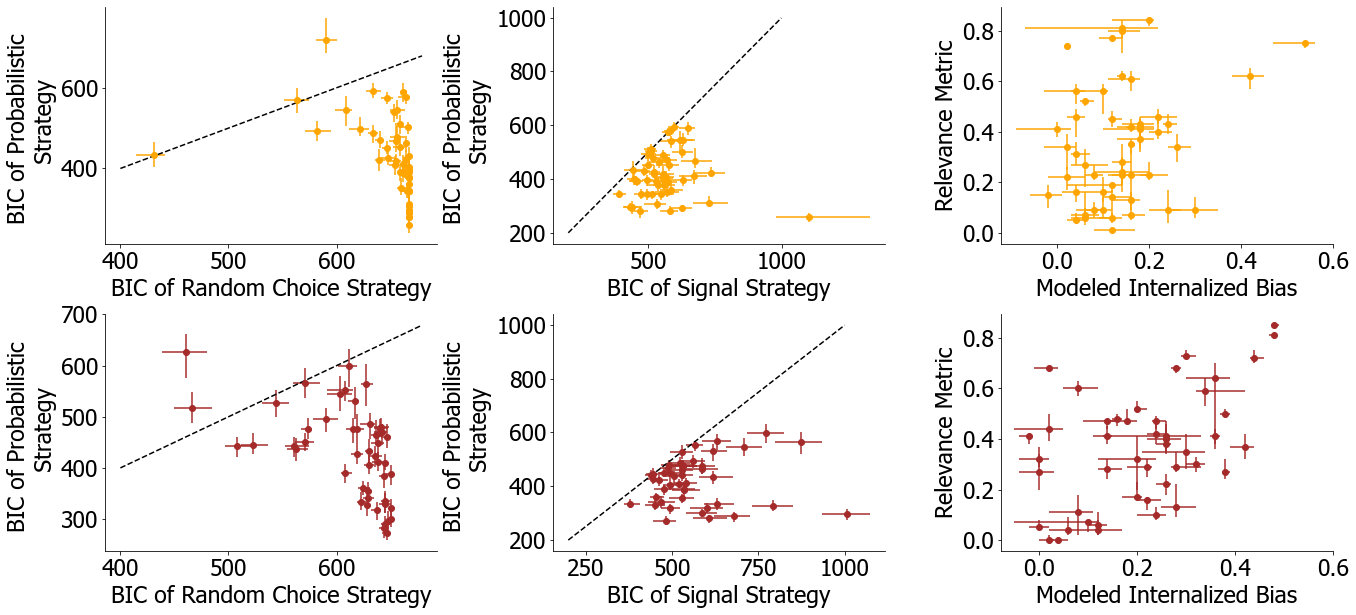

In [26]:
"""
Figure 7.
Qs: What are the trends in the long context? 
"""
computedLikelihoodsLowContext = pd.read_excel(xls,'LowContextModelFits')

bic_lowContext_signalModel = np.ma.array(computedLikelihoodsLowContext['medianFull'].values,mask=False)
bic_lowContext_signalModel = bic_lowContext_signalModel[~numpy.isnan(bic_lowContext_signalModel)]

bic_lowContext_randomModel = np.ma.array(computedLikelihoodsLowContext['medianRandom'].values,mask=False)
bic_lowContext_randomModel = bic_lowContext_randomModel[~numpy.isnan(bic_lowContext_randomModel)]

bic_lowContext_lesionModel = np.ma.array(computedLikelihoodsLowContext['medianLesion'].values,mask=False)
bic_lowContext_lesionModel = bic_lowContext_lesionModel[~numpy.isnan(bic_lowContext_lesionModel)]

bic_lowContext_lowerError_signalModel = np.ma.array(computedLikelihoodsLowContext['5thPercentileFull'].values,mask=False)
bic_lowContext_lowerError_signalModel = bic_lowContext_lowerError_signalModel[~numpy.isnan(bic_lowContext_lowerError_signalModel)]

bic_lowContext_upperError_signalModel = np.ma.array(computedLikelihoodsLowContext['95thPercentileFull'].values,mask=False)
bic_lowContext_upperError_signalModel = bic_lowContext_upperError_signalModel[~numpy.isnan(bic_lowContext_upperError_signalModel)]

bic_lowContext_lowerError_randomModel = np.ma.array(computedLikelihoodsLowContext['5thPercentileRandom'].values,mask=False)
bic_lowContext_lowerError_randomModel = bic_lowContext_lowerError_randomModel[~numpy.isnan(bic_lowContext_lowerError_randomModel)]

bic_lowContext_upperError_randomModel = np.ma.array(computedLikelihoodsLowContext['95thPercentileRandom'].values,mask=False)
bic_lowContext_upperError_randomModel = bic_lowContext_upperError_randomModel[~numpy.isnan(bic_lowContext_upperError_randomModel)]

bic_lowContext_lowerError_lesionModel = np.ma.array(computedLikelihoodsLowContext['5thPercentileLesion'].values,mask=False)
bic_lowContext_lowerError_lesionModel = bic_lowContext_lowerError_lesionModel[~numpy.isnan(bic_lowContext_lowerError_lesionModel)]

bic_lowContext_upperError_lesionModel = np.ma.array(computedLikelihoodsLowContext['95thPercentileLesion'].values,mask=False)
bic_lowContext_upperError_lesionModel = bic_lowContext_upperError_lesionModel[~numpy.isnan(bic_lowContext_upperError_lesionModel)]

size_lowContext = np.ma.array(computedLikelihoodsLowContext['sizeSubsampledDataset'].values,mask=False)
size_lowContext = size_lowContext[~np.isnan(size_lowContext)]

computedLikelihoodsHighContext = pd.read_excel(xls,'HighContextModelFits',nrows=158)

bic_highContext_signalModel = np.ma.array(computedLikelihoodsHighContext['medianFull'].values,mask=False)
bic_highContext_signalModel = bic_highContext_signalModel[~numpy.isnan(bic_highContext_signalModel)]

bic_highContext_randomModel = np.ma.array(computedLikelihoodsHighContext['medianRandom'].values,mask=False)
bic_highContext_randomModel = bic_highContext_randomModel[~numpy.isnan(bic_highContext_randomModel)]

bic_highContext_lesionModel = np.ma.array(computedLikelihoodsHighContext['medianLesion'].values,mask=False)
bic_highContext_lesionModel = bic_highContext_lesionModel[~numpy.isnan(bic_highContext_lesionModel)]

bic_highContext_lowerError_signalModel = np.ma.array(computedLikelihoodsHighContext['5thPercentileFull'].values,mask=False)
bic_highContext_lowerError_signalModel = bic_highContext_lowerError_signalModel[~numpy.isnan(bic_highContext_lowerError_signalModel)]

bic_highContext_upperError_signalModel = np.ma.array(computedLikelihoodsHighContext['95thPercentileFull'].values,mask=False)
bic_highContext_upperError_signalModel = bic_highContext_upperError_signalModel[~numpy.isnan(bic_highContext_upperError_signalModel)]

bic_highContext_lowerError_randomModel = np.ma.array(computedLikelihoodsHighContext['5thPercentileRandom'].values,mask=False)
bic_highContext_lowerError_randomModel = bic_highContext_lowerError_randomModel[~numpy.isnan(bic_highContext_lowerError_randomModel)]

bic_highContext_upperError_randomModel = np.ma.array(computedLikelihoodsHighContext['95thPercentileRandom'].values,mask=False)
bic_highContext_upperError_randomModel = bic_highContext_upperError_randomModel[~numpy.isnan(bic_highContext_upperError_randomModel)]

bic_highContext_lowerError_lesionModel = np.ma.array(computedLikelihoodsHighContext['5thPercentileLesion'].values,mask=False)
bic_highContext_lowerError_lesionModel = bic_highContext_lowerError_lesionModel[~numpy.isnan(bic_highContext_lowerError_lesionModel)]

bic_highContext_upperError_lesionModel = np.ma.array(computedLikelihoodsHighContext['95thPercentileLesion'].values,mask=False)
bic_highContext_upperError_lesionModel = bic_highContext_upperError_lesionModel[~numpy.isnan(bic_highContext_upperError_lesionModel)]

size_highContext = np.ma.array(computedLikelihoodsHighContext['sizeSubsampledDataset'].values,mask=False)
size_highContext = size_highContext[~np.isnan(size_highContext)]

pcategory_lowContextWithNan = np.ma.array(computedLikelihoodsLowContext['medianPLow'].values,mask=False)
pcategory_lowContext = pcategory_lowContextWithNan[~numpy.isnan(pcategory_lowContextWithNan)]

pcategory_lowContextWithNan_lowerError = np.ma.array(computedLikelihoodsLowContext['5thPercentilePLow'].values,mask=False)
pcategory_lowContext_lowerError = pcategory_lowContextWithNan_lowerError[~numpy.isnan(pcategory_lowContextWithNan_lowerError)]

pcategory_lowContextWithNan_upperError = np.ma.array(computedLikelihoodsLowContext['95thPercentilePLow'].values,mask=False)
pcategory_lowContext_upperError = pcategory_lowContextWithNan_upperError[~numpy.isnan(pcategory_lowContextWithNan_upperError)]

pback_lowContextWithNan = np.ma.array(computedLikelihoodsLowContext['pback'].values,mask=False)
pback_lowContext = pback_lowContextWithNan[~numpy.isnan(pback_lowContextWithNan)]

posteriorNorm_lowContextWithNan = np.ma.array(computedLikelihoodsLowContext['medianRelevanceMetric'].values,mask=False)
posteriorNorm_lowContext = posteriorNorm_lowContextWithNan[~numpy.isnan(posteriorNorm_lowContextWithNan)]

posteriorNorm_lowContextWithNan_lowerError = np.ma.array(computedLikelihoodsLowContext['5thPercentileRelevanceMetric'].values,mask=False)
posteriorNorm_lowContext_lowerError = posteriorNorm_lowContextWithNan_lowerError[~numpy.isnan(posteriorNorm_lowContextWithNan_lowerError)]

posteriorNorm_lowContextWithNan_upperError = np.ma.array(computedLikelihoodsLowContext['95thPercentileRelevanceMetric'].values,mask=False)
posteriorNorm_lowContext_upperError = posteriorNorm_lowContextWithNan_upperError[~numpy.isnan(posteriorNorm_lowContextWithNan_upperError)]

pcategory_highContextWithNan = np.ma.array(computedLikelihoodsHighContext['medianPLow'].values,mask=False)
pcategory_highContext = pcategory_highContextWithNan[~numpy.isnan(pcategory_highContextWithNan)]

pcategory_highContextWithNan_lowerError = np.ma.array(computedLikelihoodsHighContext['5thPercentilePLow'].values,mask=False)
pcategory_highContext_lowerError = pcategory_highContextWithNan_lowerError[~numpy.isnan(pcategory_highContextWithNan_lowerError)]

pcategory_highContextWithNan_upperError = np.ma.array(computedLikelihoodsHighContext['95thPercentilePLow'].values,mask=False)
pcategory_highContext_upperError = pcategory_highContextWithNan_upperError[~numpy.isnan(pcategory_highContextWithNan_upperError)]

pback_highContextWithNan = np.ma.array(computedLikelihoodsHighContext['pback'].values,mask=False)
pback_highContext = pback_highContextWithNan[~numpy.isnan(pback_highContextWithNan)]

posteriorNorm_highContextWithNan = np.ma.array(computedLikelihoodsHighContext['medianRelevanceMetric'].values,mask=False)
posteriorNorm_highContext = posteriorNorm_highContextWithNan[~numpy.isnan(posteriorNorm_highContextWithNan)]

posteriorNorm_highContextWithNan_lowerError = np.ma.array(computedLikelihoodsHighContext['5thPercentileRelevanceMetric'].values,mask=False)
posteriorNorm_highContext_lowerError = posteriorNorm_highContextWithNan_lowerError[~numpy.isnan(posteriorNorm_highContextWithNan_lowerError)]

posteriorNorm_highContextWithNan_upperError = np.ma.array(computedLikelihoodsHighContext['95thPercentileRelevanceMetric'].values,mask=False)
posteriorNorm_highContext_upperError = posteriorNorm_highContextWithNan_upperError[~numpy.isnan(posteriorNorm_highContextWithNan_upperError)]

fig, ax = plt.subplots(2,3,figsize=(22,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.35, hspace=0.3)
for i in np.arange(53):     
    ax[0,0].errorbar(2*bic_lowContext_randomModel[i]+2*np.log(size_lowContext[i]),
                 2*bic_lowContext_signalModel[i*2]+6*np.log(size_lowContext[i]), 
                 xerr=[[-2*bic_lowContext_lowerError_randomModel[i]+2*bic_lowContext_randomModel[i]],
                      [2*bic_lowContext_upperError_randomModel[i]-2*bic_lowContext_randomModel[i]]],
                 yerr=[[-2*bic_lowContext_lowerError_signalModel[i*2]+2*bic_lowContext_signalModel[i*2]],
                      [2*bic_lowContext_upperError_signalModel[i*2]-2*bic_lowContext_signalModel[i*2]]],
                 color='orange',marker='o')
for i in range(48): 
    ax[1,0].errorbar(2*bic_highContext_randomModel[i]+2*np.log(size_highContext[i]),
                 2*bic_highContext_signalModel[i]+6*np.log(size_highContext[i]), 
                 xerr=[[-2*bic_highContext_lowerError_randomModel[i]+2*bic_highContext_randomModel[i]],
                      [2*bic_highContext_upperError_randomModel[i]-2*bic_highContext_randomModel[i]]],
                 yerr=[[-2*bic_highContext_lowerError_signalModel[i]+2*bic_highContext_signalModel[i]],
                      [2*bic_highContext_upperError_signalModel[i]-2*bic_highContext_signalModel[i]]],
                 color='brown',marker='o')
    
ax[0,0].plot(np.arange(400,680),np.arange(400,680),'k--')  
ax[1,0].plot(np.arange(400,680),np.arange(400,680),'k--') 
ax[0,0].set_xlabel('BIC of Random Choice Strategy', fontsize=23)
ax[0,0].set_ylabel('BIC of Probabilistic \n Strategy',fontsize=23)
ax[0,0].tick_params(axis='both',labelsize=23)
ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)
ax[1,0].set_xlabel('BIC of Random Choice Strategy', fontsize=23)
ax[1,0].set_ylabel('BIC of Probabilistic \n Strategy',fontsize=23)
ax[1,0].tick_params(axis='both',labelsize=23)
ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)

for i in range(53):  
    if i not in [25,45]:
        ax[0,1].errorbar(2*bic_lowContext_lesionModel[i]+5*np.log(size_lowContext[i]),
                         2*bic_lowContext_signalModel[i*2]+6*np.log(size_lowContext[i]), 
                         xerr=[[-2*bic_lowContext_lowerError_lesionModel[i]+2*bic_lowContext_lesionModel[i]],
                              [2*bic_lowContext_upperError_lesionModel[i]-2*bic_lowContext_lesionModel[i]]],
                         yerr=[[-2*bic_lowContext_lowerError_signalModel[i*2]+2*bic_lowContext_signalModel[i*2]],
                              [2*bic_lowContext_upperError_signalModel[i*2]-2*bic_lowContext_signalModel[i*2]]],
                         color='orange',marker='o')
        ax[0,2].errorbar((pcategory_lowContext[i]-0.5)*2,posteriorNorm_lowContext[i], 
                         xerr=[[-pcategory_lowContext_lowerError[i]+pcategory_lowContext[i]],
                              [pcategory_lowContext_upperError[i]-pcategory_lowContext[i]]],
                         yerr=[[-posteriorNorm_lowContext_lowerError[i]+posteriorNorm_lowContext[i]],
                              [posteriorNorm_lowContext_upperError[i]-posteriorNorm_lowContext[i]]],
                         color='orange',marker='o')
for i in range(48): 
    if i not in [20,40]:
        ax[1,1].errorbar(2*bic_highContext_lesionModel[i]+5*np.log(size_highContext[i]),
                         2*bic_highContext_signalModel[i]+6*np.log(size_highContext[i]), 
                         xerr=[[-2*bic_highContext_lowerError_lesionModel[i]+2*bic_highContext_lesionModel[i]],
                              [2*bic_highContext_upperError_lesionModel[i]-2*bic_highContext_lesionModel[i]]],
                         yerr=[[-2*bic_highContext_lowerError_signalModel[i]+2*bic_highContext_signalModel[i]],
                              [2*bic_highContext_upperError_signalModel[i]-2*bic_highContext_signalModel[i]]],
                         color='brown',marker='o')
        ax[1,2].errorbar((0.5-pcategory_highContext[i])*2,posteriorNorm_highContext[i], 
                         xerr=[[-pcategory_highContext_lowerError[i]+pcategory_highContext[i]],
                              [pcategory_highContext_upperError[i]-pcategory_highContext[i]]],
                         yerr=[[-posteriorNorm_highContext_lowerError[i]+posteriorNorm_highContext[i]],
                              [posteriorNorm_highContext_upperError[i]-posteriorNorm_highContext[i]]],
                         color='brown',marker='o')
        
ax[0,1].plot(np.arange(200,1000),np.arange(200,1000),'k--')  
ax[1,1].plot(np.arange(200,1000),np.arange(200,1000),'k--') 
ax[0,1].set_xlabel('BIC of Signal Strategy', fontsize=23)
ax[0,1].set_ylabel('BIC of Probabilistic \n Strategy',fontsize=23)
ax[0,1].tick_params(axis='both',labelsize=23)
ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,2].set_xlabel('Modeled Internalized Bias',fontsize=23)
ax[0,2].set_ylabel('Relevance Metric',fontsize=23)
ax[0,2].tick_params(axis='both',labelsize=23)
ax[0,2].spines['top'].set_visible(False)
ax[0,2].spines['right'].set_visible(False)
ax[0,2].set_xticks([0,0.2,0.4,0.6])
ax[1,1].set_xlabel('BIC of Signal Strategy', fontsize=23)
ax[1,1].set_ylabel('BIC of Probabilistic \n Strategy',fontsize=23)
ax[1,1].tick_params(axis='both',labelsize=23)
ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,2].set_xlabel('Modeled Internalized Bias',fontsize=23)
ax[1,2].set_ylabel('Relevance Metric',fontsize=23)
ax[1,2].tick_params(axis='both',labelsize=23)
ax[1,2].set_xticks([0,0.2,0.4,0.6])
ax[1,2].spines['top'].set_visible(False)
ax[1,2].spines['right'].set_visible(False)
    
plt.savefig('figures/FromProlific/illustrations/uncertaintyVsRelevance_longContext.eps',bbox_inches="tight")


pback_lowContextForcomparison = np.array([0.68,0.74,0.25,0.68,0.053,0.83,0.49,0.25,0.52,0.68,0.67,0.48,0.88,0.66,0.87,
                                         0.69,0.88,0.67,0.25,0.93,0.46,0.74,0.26,0.4,0.68,0.67,0.25,0.53,0.85,0.69,0.48,
                                         0.44,0.67,0.067,0.64,0.26,0.05,0.45,0.81,0.66,0.68,0.47,0.053,0.05])
pback_noForComparisonToLowContext = np.array([0.24,0.91,0.56,0.74,0.26,0.65,0.88,0.48,0.27,0.73,0.49,0.92,0.84,0.65,0.77,
                                              0.68,0.45,0.24,0.77,0.84,0.25,0.7,0.46,0.86,0.66,0.27,0.86,0.85,0.87,0.89,
                                              0.67,0.66,0.88,0.89,0.67,0.89,0.26,0.66,0.85,0.69,0.46,0.46,0.67,0.47])

bic_lowContext_randomModel.mask[[25,45]] = True
bic_lowContext_lesionModel.mask[[25,45]] = True
bic_lowContext_signalModel.mask[[25,45]] = True
bic_highContext_randomModel.mask[[20,40]] = True
bic_highContext_lesionModel.mask[[20,40]] = True
bic_highContext_signalModel.mask[[20,40]] = True
size_lowContext.mask[[25,45]] = True
size_highContext.mask[[20,40]] = True

pcategory_lowContext.mask[[25,45]] = True
pback_lowContext.mask[[25,45]] = True
posteriorNorm_lowContext.mask[[25,45]] = True
pcategory_highContext.mask[[20,40]] = True
pback_highContext.mask[[20,40]] = True
posteriorNorm_highContext.mask[[20,40]] = True

print("Median and IQR of random model BICs low context", 
      np.median(2*bic_lowContext_randomModel+2*np.log(size_lowContext)),
      scipy.stats.iqr(2*bic_lowContext_randomModel+2*np.log(size_lowContext)))
print("Median and IQR of random model BICs high context", 
      np.median(2*bic_highContext_randomModel+2*np.log(size_highContext)),
      scipy.stats.iqr(2*bic_highContext_randomModel+2*np.log(size_highContext)))
print("Median and IQR of lesion model BICs low context", 
      np.median(2*bic_lowContext_lesionModel+5*np.log(size_lowContext)),
      scipy.stats.iqr(2*bic_lowContext_lesionModel+5*np.log(size_lowContext)))
print("Median and IQR of lesion model BICs high context", 
      np.median(2*bic_highContext_lesionModel+5*np.log(size_highContext)),
      scipy.stats.iqr(2*bic_highContext_lesionModel+5*np.log(size_highContext)))
print("Median and IQR of signal model BICs low context", 
      np.median(2*bic_lowContext_signalModel[::2]+6*np.log(size_lowContext)),
      scipy.stats.iqr(2*bic_lowContext_signalModel[::2]+6*np.log(size_lowContext)))
print("Median and IQR of signal model BICs high context", 
      np.median(2*bic_highContext_signalModel+6*np.log(size_highContext)),
      scipy.stats.iqr(2*bic_highContext_signalModel+6*np.log(size_highContext)))
print("Comparing random and signal model BICs low context using wilcoxon", 
      pg.wilcoxon(2*bic_lowContext_randomModel+2*np.log(size_lowContext), 
                  2*bic_lowContext_signalModel[::2]+6*np.log(size_lowContext)))
print("Comparing random and signal model BICs high context using wilcoxon", 
      pg.wilcoxon(2*bic_highContext_randomModel+2*np.log(size_highContext),
                  2*bic_highContext_signalModel+6*np.log(size_highContext)))
print("Comparing Lesion and signal model BICs low context using wilcoxon", 
      pg.wilcoxon(2*bic_lowContext_lesionModel+5*np.log(size_lowContext),
                  2*bic_lowContext_signalModel[::2]+6*np.log(size_lowContext)))
print("Comparing Lesion and signal model BICs high context using wilcoxon", 
      pg.wilcoxon(2*bic_highContext_lesionModel+5*np.log(size_highContext),
                  2*bic_highContext_signalModel+6*np.log(size_highContext)))

print("Correlation between plow and pdistractor in low context",
      pg.corr((pcategory_lowContext-0.5)*2,pback_lowContext[::2],method='spearman'))
print("Correlation between plow and pdistractor in high context",
      pg.corr((-pcategory_highContext+0.5)*2,pback_highContext,method='spearman'))
print("Correlation between plow and relevance metric in low context",
      pg.corr((pcategory_lowContext-0.5)*2,posteriorNorm_lowContext,method='spearman'))
print("Correlation between plow and relevance metric in high context",
      pg.corr((0.5-pcategory_highContext)*2,posteriorNorm_highContext,method='spearman'))


In [25]:
pcategory_lowContext.mask[[0,1,2,7,19]] = True
print(pcategory_lowContext)
fig, ax = plt.subplots(2,2,figsize=(22,20))
ax[0,0].plot(pcategory_lowContext[~pcategory_lowContext.mask]-0.5, 
             0.5-pcategory_highContext[~pcategory_highContext.mask],'.')
ax[0,0].plot(np.arange(0,0.4,0.05),np.arange(0,0.4,0.05),'k--')
ax[0,0].set_xlabel("Low context bias")
ax[0,0].set_ylabel("High context bias")
ax[0,0].tick_params(axis='both',labelsize=23)

ll_lowContext_signalModel = np.ma.array(computedLikelihoodsLowContext['likelihood'].values,mask=False)
ll_lowContext_signalModel = ll_lowContext_signalModel[~numpy.isnan(ll_lowContext_signalModel)]

plow_signalModel = np.ma.array(computedLikelihoodsLowContext['plow'].values,mask=False)
plow_signalModel = plow_signalModel[~numpy.isnan(plow_signalModel)]

ss_signalModel = np.ma.array(computedLikelihoodsLowContext['ss'].values,mask=False)
ss_signalModel = ss_signalModel[~numpy.isnan(ss_signalModel)]

ax[0,1].plot(ss_signalModel[::2], ss_signalModel[1::2], '.')
ax[0,1].plot(np.arange(0.1,0.6,0.05),np.arange(0.1,0.6,0.05),'k--')
ax[0,1].set_xlabel("ss constrained")
ax[0,1].set_ylabel("ss minimum")
ax[0,1].tick_params(axis='both',labelsize=23)

ax[1,0].plot(plow_signalModel[::2]-0.5, 0.5-biasLowForSubjectsWithNoAndLowContexts,'.')
ax[1,0].plot(np.arange(0,0.4,0.05),np.arange(0,0.4,0.05),'k--')
ax[1,0].tick_params(axis='both',labelsize=23)

ax[1,1].plot(plow_signalModel[1::2]-0.5, 0.5-biasLowForSubjectsWithNoAndLowContexts,'.')
ax[1,1].plot(np.arange(0,0.4,0.05),np.arange(0,0.4,0.05),'k--')
ax[1,1].tick_params(axis='both',labelsize=23)

print(pg.wilcoxon(plow_signalModel[::2]-0.5, 0.5-biasLowForSubjectsWithNoAndLowContexts))
print(pg.wilcoxon(plow_signalModel[1::2]-0.5, 0.5-biasLowForSubjectsWithNoAndLowContexts))
print("median of difference in ss:", np.mean(np.abs(ss_signalModel[::2]-ss_signalModel[1::2])))
plt.figure()
plt.hist(np.abs(ss_signalModel[::2]-ss_signalModel[1::2]))



NameError: name 'pcategory_lowContext' is not defined

average accuracy in low context when both trials are low but current stimulus has one distractor 88.54908731420734
std of accuracy in low context when both trials are low but current stimulus has one distractor 4.996955238344333
mean and std of number of trials for the above 62.37735849056604 5.867166122196199
average accuracy in low context when both trials are high but current stimulus has one distractor 84.72587192681533
std of accuracy in low context when both trials are high but current stimulus has one distractor 14.848152481434386
mean and std of number of trials for the above 10.39622641509434 2.992693130802304
           n         r          CI95%     p-val    power
spearman  53  0.180544  [-0.09, 0.43]  0.195769  0.25535
           n         r         CI95%     p-val     power
spearman  53 -0.030275  [-0.3, 0.24]  0.829614  0.055055
           n         r           CI95%         p-val     power
spearman  53 -0.728947  [-0.83, -0.57]  6.062993e-10  0.999998
           n       

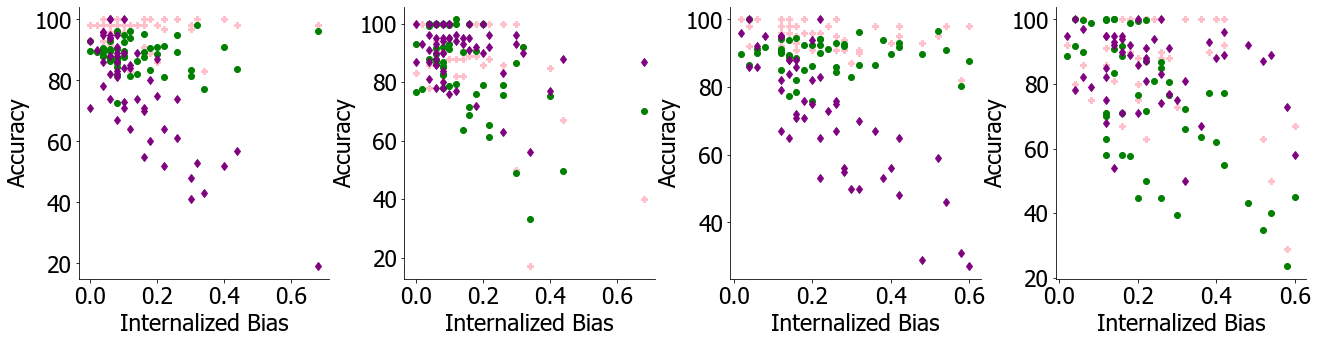

In [24]:
"""
Qs: Model free analysis of short term effects of bias.
"""

fig,[ax1,ax2,ax3,ax4] = plt.subplots(1,4,figsize=(22,5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)

ax1.plot((0.5-biasLowForAllSubjectsWithLowContext)*2, 
         internalizedBias['AccuracyOfSimpleTrialsLowContextLL']*100,
         'P',color='pink')
ax1.plot((0.5-biasLowForAllSubjectsWithLowContext)*2,
         (internalizedBias['ExpectationOfPriorCategoryLowContextLowGaussianTrials']*internalizedBias['NumberOfLowContextLowGaussianTrials']
         -internalizedBias['AccuracyOfSimpleTrialsLowContextLL']*internalizedBias['NumberOfSimpleTrialsLowContextLL'])*100/
         (internalizedBias['NumberOfLowContextLowGaussianTrials']-internalizedBias['NumberOfSimpleTrialsLowContextLL']),
         'go')
ax1.plot((0.5-biasLowForAllSubjectsWithLowContext)*2, 
         internalizedBias['AccuracyOfSimpleTrialsLowContextLH']*100,
         'purple',marker='d',linestyle='none')

ax2.plot((0.5-biasLowForAllSubjectsWithLowContext)*2,
         internalizedBias['AccuracyOfSimpleTrialsLowContextHH']*100,
         'P',color='pink')
ax2.plot((0.5-biasLowForAllSubjectsWithLowContext)*2,
         (internalizedBias['ExpectationOfPriorCategoryLowContextHighGaussianTrials']*internalizedBias['NumberOfLowContextHighGaussianTrials']
         -internalizedBias['AccuracyOfSimpleTrialsLowContextHH']*internalizedBias['NumberOfSimpleTrialsLowContextHH'])*100/
         (internalizedBias['NumberOfLowContextHighGaussianTrials']-internalizedBias['NumberOfSimpleTrialsLowContextHH']),
         'go')
ax2.plot((0.5-biasLowForAllSubjectsWithLowContext)*2, 
         internalizedBias['AccuracyOfSimpleTrialsLowContextHL']*100,
         'purple',marker='d',linestyle='none')

print("average accuracy in low context when both trials are low but current stimulus has one distractor",
     np.mean((internalizedBias['ExpectationOfPriorCategoryLowContextLowGaussianTrials']*internalizedBias['NumberOfLowContextLowGaussianTrials']
         -internalizedBias['AccuracyOfSimpleTrialsLowContextLL']*internalizedBias['NumberOfSimpleTrialsLowContextLL'])*100/
         (internalizedBias['NumberOfLowContextLowGaussianTrials']-internalizedBias['NumberOfSimpleTrialsLowContextLL'])))
print("std of accuracy in low context when both trials are low but current stimulus has one distractor",
     np.std((internalizedBias['ExpectationOfPriorCategoryLowContextLowGaussianTrials']*internalizedBias['NumberOfLowContextLowGaussianTrials']
         -internalizedBias['AccuracyOfSimpleTrialsLowContextLL']*internalizedBias['NumberOfSimpleTrialsLowContextLL'])*100/
         (internalizedBias['NumberOfLowContextLowGaussianTrials']-internalizedBias['NumberOfSimpleTrialsLowContextLL'])))
print("mean and std of number of trials for the above",
      np.mean(internalizedBias['NumberOfLowContextLowGaussianTrials']-internalizedBias['NumberOfSimpleTrialsLowContextLL']),
      np.std(internalizedBias['NumberOfLowContextLowGaussianTrials']-internalizedBias['NumberOfSimpleTrialsLowContextLL']))
print("average accuracy in low context when both trials are high but current stimulus has one distractor",
     np.mean((internalizedBias['ExpectationOfPriorCategoryLowContextHighGaussianTrials']*internalizedBias['NumberOfLowContextHighGaussianTrials']
         -internalizedBias['AccuracyOfSimpleTrialsLowContextHH']*internalizedBias['NumberOfSimpleTrialsLowContextHH'])*100/
         (internalizedBias['NumberOfLowContextHighGaussianTrials']-internalizedBias['NumberOfSimpleTrialsLowContextHH'])))
print("std of accuracy in low context when both trials are high but current stimulus has one distractor",
     np.std((internalizedBias['ExpectationOfPriorCategoryLowContextHighGaussianTrials']*internalizedBias['NumberOfLowContextHighGaussianTrials']
         -internalizedBias['AccuracyOfSimpleTrialsLowContextHH']*internalizedBias['NumberOfSimpleTrialsLowContextHH'])*100/
         (internalizedBias['NumberOfLowContextHighGaussianTrials']-internalizedBias['NumberOfSimpleTrialsLowContextHH'])))
print("mean and std of number of trials for the above",
      np.mean(internalizedBias['NumberOfLowContextHighGaussianTrials']-internalizedBias['NumberOfSimpleTrialsLowContextHH']),
      np.std(internalizedBias['NumberOfLowContextHighGaussianTrials']-internalizedBias['NumberOfSimpleTrialsLowContextHH']))

print(pg.corr(0.5-biasLowForAllSubjectsWithLowContext,
              internalizedBias['AccuracyOfSimpleTrialsLowContextLL'], method='spearman'))
print(pg.corr(0.5-biasLowForAllSubjectsWithLowContext,
              (internalizedBias['ExpectationOfPriorCategoryLowContextLowGaussianTrials']*internalizedBias['NumberOfLowContextLowGaussianTrials']
         -internalizedBias['AccuracyOfSimpleTrialsLowContextLL']*internalizedBias['NumberOfSimpleTrialsLowContextLL'])/
         (internalizedBias['NumberOfLowContextLowGaussianTrials']-internalizedBias['NumberOfSimpleTrialsLowContextLL']),
             method='spearman'))
print(pg.corr(0.5-biasLowForAllSubjectsWithLowContext,
              internalizedBias['AccuracyOfSimpleTrialsLowContextLH'], method='spearman'))
print(pg.corr(0.5-biasLowForAllSubjectsWithLowContext,
              internalizedBias['AccuracyOfSimpleTrialsLowContextHH'], method='spearman'))
print(pg.corr(0.5-biasLowForAllSubjectsWithLowContext,
              (internalizedBias['ExpectationOfPriorCategoryLowContextHighGaussianTrials']*internalizedBias['NumberOfLowContextHighGaussianTrials']
         -internalizedBias['AccuracyOfSimpleTrialsLowContextHH']*internalizedBias['NumberOfSimpleTrialsLowContextHH'])/
         (internalizedBias['NumberOfLowContextHighGaussianTrials']-internalizedBias['NumberOfSimpleTrialsLowContextHH']),
             method='spearman'))
print(pg.corr(0.5-biasLowForAllSubjectsWithLowContext,
              internalizedBias['AccuracyOfSimpleTrialsLowContextHL'], method='spearman'))

ax3.plot((biasHighForAllSubjectsWithHighContext-0.5)*2, 
         internalizedBias['AccuracyOfSimpleTrialsHighContextHH'][~np.isnan(internalizedBias['AccuracyOfSimpleTrialsHighContextHH'])]*100,
         'P',color='pink')
ax3.plot((biasHighForAllSubjectsWithHighContext-0.5)*2,
         (internalizedBias['ExpectationOfPriorCategoryHighContextHighGaussianTrials'][~np.isnan(internalizedBias['ExpectationOfPriorCategoryHighContextHighGaussianTrials'])]
          *internalizedBias['NumberOfHighContextHighGaussianTrials'][~np.isnan(internalizedBias['NumberOfHighContextHighGaussianTrials'])]
         -internalizedBias['AccuracyOfSimpleTrialsHighContextHH'][~np.isnan(internalizedBias['AccuracyOfSimpleTrialsHighContextHH'])]
          *internalizedBias['NumberOfSimpleTrialsHighContextHH'][~np.isnan(internalizedBias['NumberOfSimpleTrialsHighContextHH'])])*100/
         (internalizedBias['NumberOfHighContextHighGaussianTrials'][~np.isnan(internalizedBias['NumberOfHighContextHighGaussianTrials'])]
          -internalizedBias['NumberOfSimpleTrialsHighContextHH'][~np.isnan(internalizedBias['NumberOfSimpleTrialsHighContextHH'])]),
         'go')
ax3.plot((biasHighForAllSubjectsWithHighContext-0.5)*2, 
         internalizedBias['AccuracyOfSimpleTrialsHighContextHL'][~np.isnan(internalizedBias['AccuracyOfSimpleTrialsHighContextHL'])]*100,
         'purple',marker='d',linestyle='none')
ax4.plot((biasHighForAllSubjectsWithHighContext-0.5)*2,
         internalizedBias['AccuracyOfSimpleTrialsHighContextLL'][~np.isnan(internalizedBias['AccuracyOfSimpleTrialsHighContextLL'])]*100,
         'P',color='pink')
ax4.plot((biasHighForAllSubjectsWithHighContext-0.5)*2,
         (internalizedBias['ExpectationOfPriorCategoryHighContextLowGaussianTrials'][~np.isnan(internalizedBias['ExpectationOfPriorCategoryHighContextLowGaussianTrials'])]
          *internalizedBias['NumberOfHighContextLowGaussianTrials'][~np.isnan(internalizedBias['NumberOfHighContextLowGaussianTrials'])]
         -internalizedBias['AccuracyOfSimpleTrialsHighContextLL'][~np.isnan(internalizedBias['AccuracyOfSimpleTrialsHighContextLL'])]
          *internalizedBias['NumberOfSimpleTrialsHighContextLL'][~np.isnan(internalizedBias['NumberOfSimpleTrialsHighContextLL'])])*100/
         (internalizedBias['NumberOfHighContextLowGaussianTrials'][~np.isnan(internalizedBias['NumberOfHighContextLowGaussianTrials'])]
          -internalizedBias['NumberOfSimpleTrialsHighContextLL'][~np.isnan(internalizedBias['NumberOfSimpleTrialsHighContextLL'])]),
         'go')
ax4.plot((biasHighForAllSubjectsWithHighContext-0.5)*2, 
         internalizedBias['AccuracyOfSimpleTrialsHighContextLH'][~np.isnan(internalizedBias['AccuracyOfSimpleTrialsHighContextLH'])]*100,
         'purple',marker='d',linestyle='none')

print("average accuracy in high context when both trials are high but current stimulus has one distractor",
     np.mean((internalizedBias['ExpectationOfPriorCategoryHighContextHighGaussianTrials'][~np.isnan(internalizedBias['ExpectationOfPriorCategoryHighContextHighGaussianTrials'])]
          *internalizedBias['NumberOfHighContextHighGaussianTrials'][~np.isnan(internalizedBias['NumberOfHighContextHighGaussianTrials'])]
         -internalizedBias['AccuracyOfSimpleTrialsHighContextHH'][~np.isnan(internalizedBias['AccuracyOfSimpleTrialsHighContextHH'])]
          *internalizedBias['NumberOfSimpleTrialsHighContextHH'][~np.isnan(internalizedBias['NumberOfSimpleTrialsHighContextHH'])])*100/
         (internalizedBias['NumberOfHighContextHighGaussianTrials'][~np.isnan(internalizedBias['NumberOfHighContextHighGaussianTrials'])]
          -internalizedBias['NumberOfSimpleTrialsHighContextHH'][~np.isnan(internalizedBias['NumberOfSimpleTrialsHighContextHH'])])))
print("std of accuracy in high context when both trials are high but current stimulus has one distractor",
     np.std((internalizedBias['ExpectationOfPriorCategoryHighContextHighGaussianTrials'][~np.isnan(internalizedBias['ExpectationOfPriorCategoryHighContextHighGaussianTrials'])]
          *internalizedBias['NumberOfHighContextHighGaussianTrials'][~np.isnan(internalizedBias['NumberOfHighContextHighGaussianTrials'])]
         -internalizedBias['AccuracyOfSimpleTrialsHighContextHH'][~np.isnan(internalizedBias['AccuracyOfSimpleTrialsHighContextHH'])]
          *internalizedBias['NumberOfSimpleTrialsHighContextHH'][~np.isnan(internalizedBias['NumberOfSimpleTrialsHighContextHH'])])*100/
         (internalizedBias['NumberOfHighContextHighGaussianTrials'][~np.isnan(internalizedBias['NumberOfHighContextHighGaussianTrials'])]
          -internalizedBias['NumberOfSimpleTrialsHighContextHH'][~np.isnan(internalizedBias['NumberOfSimpleTrialsHighContextHH'])])))
print("mean and std of number of trials for the above",
      np.mean(internalizedBias['NumberOfHighContextHighGaussianTrials'][~np.isnan(internalizedBias['NumberOfHighContextHighGaussianTrials'])]
              -internalizedBias['NumberOfSimpleTrialsHighContextHH'][~np.isnan(internalizedBias['NumberOfSimpleTrialsHighContextHH'])]),
      np.std(internalizedBias['NumberOfHighContextHighGaussianTrials'][~np.isnan(internalizedBias['NumberOfHighContextHighGaussianTrials'])]
              -internalizedBias['NumberOfSimpleTrialsHighContextHH'][~np.isnan(internalizedBias['NumberOfSimpleTrialsHighContextHH'])]))

print("average accuracy in high context when both trials are low but current stimulus has one distractor",
     np.mean((internalizedBias['ExpectationOfPriorCategoryHighContextLowGaussianTrials'][~np.isnan(internalizedBias['ExpectationOfPriorCategoryHighContextLowGaussianTrials'])]
          *internalizedBias['NumberOfHighContextLowGaussianTrials'][~np.isnan(internalizedBias['NumberOfHighContextLowGaussianTrials'])]
         -internalizedBias['AccuracyOfSimpleTrialsHighContextLL'][~np.isnan(internalizedBias['AccuracyOfSimpleTrialsHighContextLL'])]
          *internalizedBias['NumberOfSimpleTrialsHighContextLL'][~np.isnan(internalizedBias['NumberOfSimpleTrialsHighContextLL'])])*100/
         (internalizedBias['NumberOfHighContextLowGaussianTrials'][~np.isnan(internalizedBias['NumberOfHighContextLowGaussianTrials'])]
          -internalizedBias['NumberOfSimpleTrialsHighContextLL'][~np.isnan(internalizedBias['NumberOfSimpleTrialsHighContextLL'])])))
print("std of accuracy in high context when both trials are low but current stimulus has one distractor",
     np.std((internalizedBias['ExpectationOfPriorCategoryHighContextLowGaussianTrials'][~np.isnan(internalizedBias['ExpectationOfPriorCategoryHighContextLowGaussianTrials'])]
          *internalizedBias['NumberOfHighContextLowGaussianTrials'][~np.isnan(internalizedBias['NumberOfHighContextLowGaussianTrials'])]
         -internalizedBias['AccuracyOfSimpleTrialsHighContextLL'][~np.isnan(internalizedBias['AccuracyOfSimpleTrialsHighContextLL'])]
          *internalizedBias['NumberOfSimpleTrialsHighContextLL'][~np.isnan(internalizedBias['NumberOfSimpleTrialsHighContextLL'])])*100/
         (internalizedBias['NumberOfHighContextLowGaussianTrials'][~np.isnan(internalizedBias['NumberOfHighContextLowGaussianTrials'])]
          -internalizedBias['NumberOfSimpleTrialsHighContextLL'][~np.isnan(internalizedBias['NumberOfSimpleTrialsHighContextLL'])])))
print("mean and std of number of trials for the above",
      np.mean(internalizedBias['NumberOfHighContextLowGaussianTrials'][~np.isnan(internalizedBias['NumberOfHighContextLowGaussianTrials'])]
              -internalizedBias['NumberOfSimpleTrialsHighContextLL'][~np.isnan(internalizedBias['NumberOfSimpleTrialsHighContextLL'])]),
      np.std(internalizedBias['NumberOfHighContextLowGaussianTrials'][~np.isnan(internalizedBias['NumberOfHighContextLowGaussianTrials'])]
              -internalizedBias['NumberOfSimpleTrialsHighContextLL'][~np.isnan(internalizedBias['NumberOfSimpleTrialsHighContextLL'])]))

print(pg.corr(-0.5+biasHighForAllSubjectsWithHighContext,
              internalizedBias['AccuracyOfSimpleTrialsHighContextHH'][~np.isnan(internalizedBias['AccuracyOfSimpleTrialsHighContextHH'])], method='spearman'))
print(pg.corr(-0.5+biasHighForAllSubjectsWithHighContext,
              (internalizedBias['ExpectationOfPriorCategoryHighContextHighGaussianTrials'][~np.isnan(internalizedBias['ExpectationOfPriorCategoryHighContextHighGaussianTrials'])]
          *internalizedBias['NumberOfHighContextHighGaussianTrials'][~np.isnan(internalizedBias['NumberOfHighContextHighGaussianTrials'])]
         -internalizedBias['AccuracyOfSimpleTrialsHighContextHH'][~np.isnan(internalizedBias['AccuracyOfSimpleTrialsHighContextHH'])]
          *internalizedBias['NumberOfSimpleTrialsHighContextHH'][~np.isnan(internalizedBias['NumberOfSimpleTrialsHighContextHH'])])*100/
         (internalizedBias['NumberOfHighContextHighGaussianTrials'][~np.isnan(internalizedBias['NumberOfHighContextHighGaussianTrials'])]
          -internalizedBias['NumberOfSimpleTrialsHighContextHH'][~np.isnan(internalizedBias['NumberOfSimpleTrialsHighContextHH'])]),
             method='spearman'))
print(pg.corr(-0.5+biasHighForAllSubjectsWithHighContext,
              internalizedBias['AccuracyOfSimpleTrialsHighContextHL'][~np.isnan(internalizedBias['AccuracyOfSimpleTrialsHighContextHL'])], method='spearman'))
print(pg.corr(-0.5+biasHighForAllSubjectsWithHighContext,
              internalizedBias['AccuracyOfSimpleTrialsHighContextLL'][~np.isnan(internalizedBias['AccuracyOfSimpleTrialsHighContextLL'])], method='spearman'))
print(pg.corr(-0.5+biasHighForAllSubjectsWithHighContext,
              (internalizedBias['ExpectationOfPriorCategoryHighContextLowGaussianTrials'][~np.isnan(internalizedBias['ExpectationOfPriorCategoryHighContextLowGaussianTrials'])]
              *internalizedBias['NumberOfHighContextLowGaussianTrials'][~np.isnan(internalizedBias['NumberOfHighContextLowGaussianTrials'])]
             -internalizedBias['AccuracyOfSimpleTrialsHighContextLL'][~np.isnan(internalizedBias['AccuracyOfSimpleTrialsHighContextLL'])]
              *internalizedBias['NumberOfSimpleTrialsHighContextLL'][~np.isnan(internalizedBias['NumberOfSimpleTrialsHighContextLL'])])*100/
            (internalizedBias['NumberOfHighContextLowGaussianTrials'][~np.isnan(internalizedBias['NumberOfHighContextLowGaussianTrials'])]
              -internalizedBias['NumberOfSimpleTrialsHighContextLL'][~np.isnan(internalizedBias['NumberOfSimpleTrialsHighContextLL'])]),
              method='spearman'))
print(pg.corr(-0.5+biasHighForAllSubjectsWithHighContext,
              internalizedBias['AccuracyOfSimpleTrialsHighContextLH'][~np.isnan(internalizedBias['AccuracyOfSimpleTrialsHighContextLH'])], method='spearman'))


ax1.set_xlabel('Internalized Bias', fontsize=23)
ax1.set_ylabel('Accuracy',fontsize=23)
ax1.tick_params(axis='both',labelsize=23)
ax1.set_xticks(np.arange(0,0.7,0.2))
ax1.set_xticklabels(np.around(np.arange(0,0.7,0.2),1),fontsize=23)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.set_xlabel('Internalized Bias', fontsize=23)
ax2.set_ylabel('Accuracy',fontsize=23)
ax2.tick_params(axis='both',labelsize=23)
ax2.set_xticks(np.arange(0,0.7,0.2))
ax2.set_xticklabels(np.around(np.arange(0,0.7,0.2),1),fontsize=23)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax3.set_xlabel('Internalized Bias', fontsize=23)
ax3.set_ylabel('Accuracy',fontsize=23)
ax3.tick_params(axis='both',labelsize=23)
ax3.set_xticks(np.arange(0,0.7,0.2))
ax3.set_xticklabels(np.around(np.arange(0,0.7,0.2),1),fontsize=23)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax4.set_xlabel('Internalized Bias', fontsize=23)
ax4.set_ylabel('Accuracy',fontsize=23)
ax4.tick_params(axis='both',labelsize=23)
ax4.set_xticks(np.arange(0,0.7,0.2))
ax4.set_xticklabels(np.around(np.arange(0,0.7,0.2),1),fontsize=23)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

#plt.savefig('figures/FromProlific/illustrations/biasEffectsOnTrialPairs_longContext.eps',bbox_inches="tight")




## From here on Discarded code


In [ ]:

"""
Qs: are accuracy and bias correlated in the no context case?
"""
accuracyNo = np.array([81.5,73.5,82.6,82.8,67.8,82.3,74.9,81.2,79.2,74.9,78.1,80.5,79.1,84.5,83,
                       76.7,85.7,72.3,80.5,85.1,74.3,79.7,76.7,68.9,72,78.8,86,84.6,83.6])
biasNo = np.array([0.49,0.57,0.49,0.49,0.49,0.48,0.51,0.53,0.49,0.51,0.53,0.48,0.53,0.48,
                   0.46,0.49,0.5,0.46,0.51,0.47,0.54,0.52,0.47,0.44,0.44,0.46,0.48,0.49,0.49])
fig, ax = plt.subplots()
ax.plot(biasNo,accuracyNo,'k.')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Internalized Bias',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
#plt.savefig('figures/FromProlific/illustrations/accuracyVsBiasNoContext',bbox_inches="tight")

"""
Qs: Are strategies the same in no and long context?
"""

noContextSubjectsSigMean = ['735a','1c3f','1396','2099']
noContextSubjectsVoting = ['5b34','c2e0','8de3','6b7f','1604','801d','54db','b4c7','a12e','c653','4b7f',
                          'fc3a','1570','592d','a45d','0cf1','214b','b7cc','6ced','188a','e12e']
noContextSubjectsMean = ['d619','1304','0d04','e453']

lowContextSubjectsAll = ['d619','c2e0','735a','1304','6b7f','1c3f','1604','801d','1396','b4c7','a12e',
                         'c653','4b7f','fc3a','0d04','2099','592d','a45d','0cf1','e453','214b',
                            'b7cc','6ced','188a','e12e']
lowContextSubjectsSigMean = ['d619','c2e0','735a','1304','1c3f','c653','0d04','2099','592d','214b','e12e']
lowContextSubjectsVoting = ['6b7f','801d','1396','b4c7','a12e','4b7f','fc3a','1570','a45d','0cf1','e453',
                            'b7cc','6ced','188a']
lowContextSubjectsMean = ['1604']

fig, ax = plt.subplots()
for iSubject in noContextSubjectsSigMean:
    if iSubject in lowContextSubjectsSigMean:
        ax.plot(1,np.random.randn()*0.1+1,'b.')
    elif iSubject in lowContextSubjectsVoting:
        ax.plot(1,np.random.randn()*0.1+2,'b.')
    elif iSubject in lowContextSubjectsMean:
        ax.plot(1,np.random.randn()*0.1+3,'b.')
        
for iSubject in noContextSubjectsVoting:
    if iSubject in lowContextSubjectsSigMean:
        ax.plot(2,np.random.randn()*0.1+1,'b.')
    elif iSubject in lowContextSubjectsVoting:
        ax.plot(2,np.random.randn()*0.1+2,'b.')
    elif iSubject in lowContextSubjectsMean:
        ax.plot(2,np.random.randn()*0.1+3,'b.')
        
for iSubject in noContextSubjectsMean:
    if iSubject in lowContextSubjectsSigMean:
        ax.plot(3,np.random.randn()*0.1+1,'b.')
    elif iSubject in lowContextSubjectsVoting:
        ax.plot(3,np.random.randn()*0.1+2,'b.')
    elif iSubject in lowContextSubjectsMean:
        ax.plot(3,np.random.randn()*0.1+3,'b.')
ax.set_xticks([1,2,3])
ax.set_xticklabels(['Mean of Signal','Voting','Mean of all'],fontsize=14)
ax.set_yticks([1,2,3])
ax.set_yticklabels(['Mean of Signal','Voting','Mean of all'],fontsize=14)

"""
Qs:how do strategies and bias interplay in the long context scenarios?
"""

fig, [ax1,ax2] = plt.subplots(1,2,sharex=True,figsize=[20,5])
for iSubject in range(len(lowContextSubjectsAll)):
    if lowContextSubjectsAll[iSubject] in lowContextSubjectsSigMean:
        ax1.plot(1,0.5-biasLow[iSubject],'b.')
        ax2.plot(1,accuracyLow[iSubject],'b*')
    elif lowContextSubjectsAll[iSubject] in lowContextSubjectsVoting:
        ax1.plot(2,0.5-biasLow[iSubject],'b.')
        ax2.plot(2,accuracyLow[iSubject],'b*')
    elif lowContextSubjectsAll[iSubject] in lowContextSubjectsMean:
        ax1.plot(3,0.5-biasLow[iSubject],'b.')
        ax2.plot(3,accuracyLow[iSubject],'b*')

In [ ]:
"""
The following variables are for bic values of the entire dataset.
"""
bic_meanModel = 2*np.array([311.78,296,366.67,362.62,381.75,304.45,290.95,381.91,287.53,293.13,385,254.11,288.05,
                 248.98,337.35,295.97,305.18,378.12,344.81,413.92,329.65,331.31,280.72,310.66,354.75,258.69,
                318.33,312.08,401.44])
bic_signalModel = 2*np.array([227.51, 277.09,222.37,203.26, 367.84,233.56,264.95,229.66,243.16,263.38,267.19,
                           204.64,256.01,170.87,200.08,268.11,176.17,301.37,218.84,184.93,287.37,238.48,238.84,
                           309.79,323.45,219.93,157.15,178.92,202.52])
bic_votingModel = 2*np.array([233.22,280.1,245.63,233.77,369.2,234.79,265.85,243.82,249.72,265.95,285.31,203.48,
                           258.35,173.28,220.8,267.46,185.68,315.17,232.01,230.61,286.29,249.47,249.77,309.9,
                            322.7,217.33,152.39,171.85,195.91]) 

percentageDataExplainedByMean = np.array([68.5,73.6,67.7,64.2,64,70.1,74.9,62.4,75.3,76.8,61.3,79.4,72.5,
                                          74.2,68.7,74.2,71.4,71.4,67.3,61.1,71.8,71.6,76.4,78.5,67.5,75.9,
                                          71.7,74.1,66.8])
percentageDataExplainedBySig = np.array([74.2,61.5,74.3,78,59.6,75.1,64.3,82.4,64.6,61,73.8,64.7,67.2,71.1,
                                         73,63.8,75.5,57.9,76,82.1,66.4,63.5,64.2,53.1,68.1,66.8,73,70.5,77.2])
percentageDataExplainedByVoting = np.array([80.5,73.5,79.4,76.9,61.5,82.2,81.9,79.2,78.2,79,72.5,83.8,79.9,
                                            89.5,80.8,79.5,85.7,70.9,78.7,79.1,78.7,78.5,76.7,72.7,74,81.5,90.6,
                                            89.8,88.5])

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(20,5))
ax1.plot(bic_meanModel+5*np.log(600),bic_signalModel+6*np.log(600),'ko')
ax1.plot(bic_meanModel[23]+5*np.log(600),bic_signalModel[23]+6*np.log(600),marker='$\\bigoplus$',color='royalblue')
ax1.plot(bic_meanModel[19]+5*np.log(600),bic_signalModel[19]+6*np.log(600),marker='$\\bigoplus$',color='red')
ax1.plot(bic_meanModel[3]+5*np.log(600),bic_signalModel[3]+6*np.log(600),marker='$\\bigoplus$',color='red')
ax1.plot(np.arange(450,850),np.arange(450,850),'k--')
#ax1.hlines(0,-5,250,'k',linestyles='--')
#ax1.vlines(0,-30,30,'k',linestyles='--')
ax1.set_xlabel('BIC Lesion Model', fontsize=20)
ax1.set_ylabel('BIC Signal Model',fontsize=20)
ax1.tick_params(axis='both',labelsize=20)

ax2.plot(bic_votingModel+5*np.log(600),bic_signalModel+6*np.log(600),'ko')
ax2.plot(bic_votingModel[-1]+5*np.log(600),bic_signalModel[-1]+6*np.log(600),marker='$\\bigoplus$',color='limegreen')
ax2.plot(bic_votingModel[-2]+5*np.log(600),bic_signalModel[-2]+6*np.log(600),marker='$\\bigoplus$',color='limegreen')
ax2.plot(bic_votingModel[-3]+5*np.log(600),bic_signalModel[-3]+6*np.log(600),marker='$\\bigoplus$',color='limegreen')
ax2.plot(bic_votingModel[19]+5*np.log(600),bic_signalModel[19]+6*np.log(600),marker='$\\bigoplus$',color='red')
ax2.plot(bic_votingModel[3]+5*np.log(600),bic_signalModel[3]+6*np.log(600),marker='$\\bigoplus$',color='red')
ax2.plot(bic_votingModel[10]+5*np.log(600),bic_signalModel[10]+6*np.log(600),marker='$\\bigoplus$',color='red')

ax2.plot(np.arange(300,800),np.arange(300,800),'k--')
ax2.set_xlabel('BIC Voting Model', fontsize=20)
ax2.set_ylabel('BIC Signal Model',fontsize=20)
ax2.tick_params(axis='both',labelsize=20)
#plt.savefig('figures/FromProlific/illustrations/comparingBICAcrossStrategy',bbox_inches="tight")


In [ ]:
"""
Qs: how is accuracy correlated with pback? For this I am using the pback calculated on the bootstrap sampled
dataset.
"""
fig,ax = plt.subplots(1,1,figsize=(10,5))
for iSubj in range(len(pbackCalcuatedOnSubsampledDataset)//2):
    ax.plot(OneIrrelevantToneAccuracy[iSubj],TwoIrrelevantTonesAccuracy[iSubj],marker='o',
            color=[pbackCalcuatedOnSubsampledDataset[iSubj*2],pbackCalcuatedOnSubsampledDataset[iSubj*2],
                   pbackCalcuatedOnSubsampledDataset[iSubj*2]])
ax.set_xlabel('Accuracy for trials with one irrelevant experimental tone',fontsize=18)
ax.set_ylabel('Accuracy for trials with two \n irrelevant experimental tones',fontsize=18)
ax.tick_params(axis='both',labelsize=15)

fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection='3d')
for iSubj in range(len(pbackCalcuatedOnSubsampledDataset)//2):
    ax.plot3D(OneIrrelevantToneAccuracy[iSubj],TwoIrrelevantTonesAccuracy[iSubj],
              pbackCalcuatedOnSubsampledDataset[iSubj*2],'ko')
ax.set_xlabel("Accuracy for trials with \n one irrelevant experimental tone",fontsize=10)
ax.set_ylabel('Accuracy for trials with two \n irrelevant experimental tones',fontsize=10)
ax.set_zlabel('P$_{distractor}$',fontsize=15)